# Prephase
This notebook is for conducting an analysis, no finite plots will be constructed here.

# Uploads

In [14]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import cooler
import pyranges as pr
from statsmodels.stats.multitest import multipletests as fdr_correction
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
 
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

from glob import glob
import json
from os.path import basename, splitext
from importlib import reload
import gffpandas.gffpandas as gffpd
from natsort import natsorted

import utils
from utils.anova import *
from utils.gene_intervals import bins_to_genes_intersection
from utils.plot_functions import *
from utils.hic_preproc import *
reload(utils.anova)
reload(utils.plot_functions)
reload(utils.hic_preproc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils.hic_preproc' from '/home/dkriukov/mice/Aging_Brain_Mice/utils/hic_preproc.py'>

In [15]:
#crucial work dirs
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
TAD_PATH = '/tank/projects/kriukov_chromatin/HIC/tads'
LOOP_PATH = '/tank/projects/kriukov_chromatin/HIC/loops'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
ATAC_FOLDER_PATH = '/tank/projects/kriukov_chromatin/ATAC'

In [26]:
#import genes
gffpath = '%s/GCF_000001635.27_GRCm39_genomic.gff' % GENOME_FOLDER_PATH
annot_path = '%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH
#refseq to chrom annotation
annotation = gffpd.read_gff3(gffpath)
fasta_annot = pd.read_csv(annot_path, sep='\t', skiprows=28)
refseq2chrom = dict(zip(fasta_annot['RefSeq-Accn'].values, fasta_annot['UCSC-style-name'].values))
gn = annotation.attributes_to_columns()
gn.seq_id = gn.seq_id.map(refseq2chrom)
gn['length'] = gn['end'] - gn['start']
gn = gn[['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand',
         'ID', 'Name', 'description', 'length', 'chromosome']]

#types of sequences
gn_code = gn[gn['type']=='gene'] #protein codeing
gn_lnc = gn[gn['type']=='lnc_RNA'] #long non-coding
gn_trna = gn[gn['type']=='tRNA'] #tRNA
gn_rrna = gn[gn['type']=='rRNA'] #rRNA

In [3]:
!ls /tank/projects/kriukov_chromatin/GENOME

GCF_000001635.27_GRCm39_assembly_report.txt  chrfile.txt
GCF_000001635.27_GRCm39_genomic.fna	     chrom_arms.txt
GCF_000001635.27_GRCm39_genomic.fna.fai      data
GCF_000001635.27_GRCm39_genomic.gff


In [4]:
!ls /tank/projects/kriukov_chromatin/HIC/

KO_coolers_library		     downsampled
KO_female_2.mm10.mapq_30.1000.mcool  insulation
KO_female_3.mm10.mapq_30.1000.mcool  loops
KO_male_1.mm10.mapq_30.1000.mcool    old_female_2.mm10.mapq_30.1000.mcool
OLD_coolers_library		     old_female_3.mm10.mapq_30.1000.mcool
Results				     old_male_1.mm10.mapq_30.1000.mcool
WT_coolers_library		     preB
WT_female_2.mm10.mapq_30.1000.mcool  tads
WT_female_3.mm10.mapq_30.1000.mcool  young_female_2.mm10.mapq_30.1000.mcool
WT_male_1.mm10.mapq_30.1000.mcool    young_female_3.mm10.mapq_30.1000.mcool
YOUNG_coolers_library		     young_male_1.mm10.mapq_30.1000.mcool
compartments


In [5]:
RESOLUTION = 50000
downsampled = True
merged = False

if downsampled:
    if merged:
        FILES = natsorted(glob('%s/merged/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
        CLRS = [cooler.Cooler(p) for p in FILES]
    else:
        FILES = natsorted(glob('%s/*%s.cool' % (DOWNSAMPLED_FOLDER_PATH, RESOLUTION)))
        CLRS = [cooler.Cooler(p) for p in FILES]
else:
    FILES = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))
    CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]

CLRS_DICT = dict(zip([basename(c.filename).split('_')[1] for c in CLRS], CLRS)) #### tmp!

#compartments
eigval_files = natsorted(glob(COMPARTMENTS_PATH + '/combined*lam.txt'))
eigvec_files = natsorted(glob(COMPARTMENTS_PATH + '/combined*vecs.txt'))
eigvec = {l:pd.read_csv(f, sep='\t') for l, f in zip(['KO', 'WT', 'old', 'young'], eigvec_files)}
eigval = {l:pd.read_csv(f, sep='\t', index_col=1) for l, f in zip(['KO', 'WT', 'old', 'young'], eigval_files)}

#insulation score
#IS = pd.read_csv('%s/IS_25000.csv' % INSULATION_PATH, index_col=0)
IS = pd.read_csv('%s/IS_50000.csv' % INSULATION_PATH, index_col=0)

#consensus peaks
ATAC = pd.read_csv('%s/consensus_peaks.mLb.clN.boolean.annotatePeaks.txt' % ATAC_FOLDER_PATH, sep='\t')

#TADs
TADS = json.load(open(TAD_PATH + '/' + 'lavaburst_tads_arkuda.json', 'r'))

#diffexpressed genes
slopes = pd.read_csv('subdata/diffexp_result.csv', index_col=0)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Basic vizualization

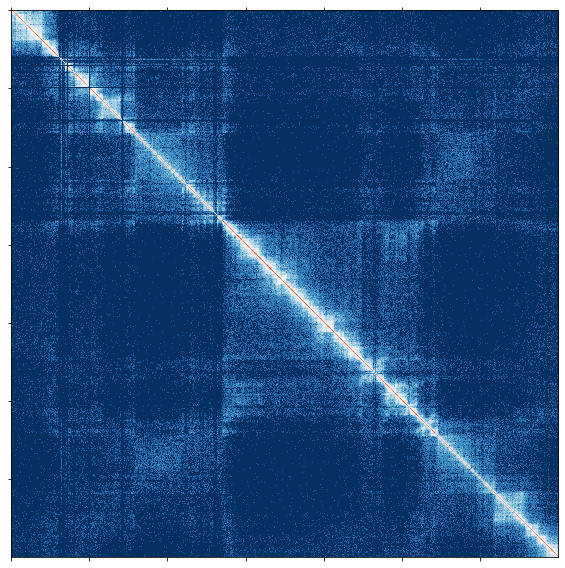

In [6]:
import cooltools
from matplotlib.colors import LogNorm
import cooltools.lib.plotting
### plot the corrected data in fall heatmap ###

clr = CLRS[0]

### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    #print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

region = 'chr17:10,000,000-45,000,000'
vmax = 200
vmin = 1
#norm = LogNorm(vmin=vmin, vmax=vmax)
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

f, ax = plt.subplots(
    figsize=(8.6, 8),
    nrows=1,
    ncols=1,
    sharex=True, sharey=True)

ax.set_xticklabels([])
ax.set_yticklabels([])
im = ax.matshow(
    np.log10(clr.matrix(balance=False).fetch(region) + 1), 
    #vmax=vmax, 
    #vmin=vmin, 
    cmap='RdBu_r')
#plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, norm=norm)
#plt.xticks(chromstarts,clr.chromnames);

plt.tight_layout()
plt.savefig('figs/hic_miniature.pdf', format='pdf', dpi=300, bbox_inches='tight')

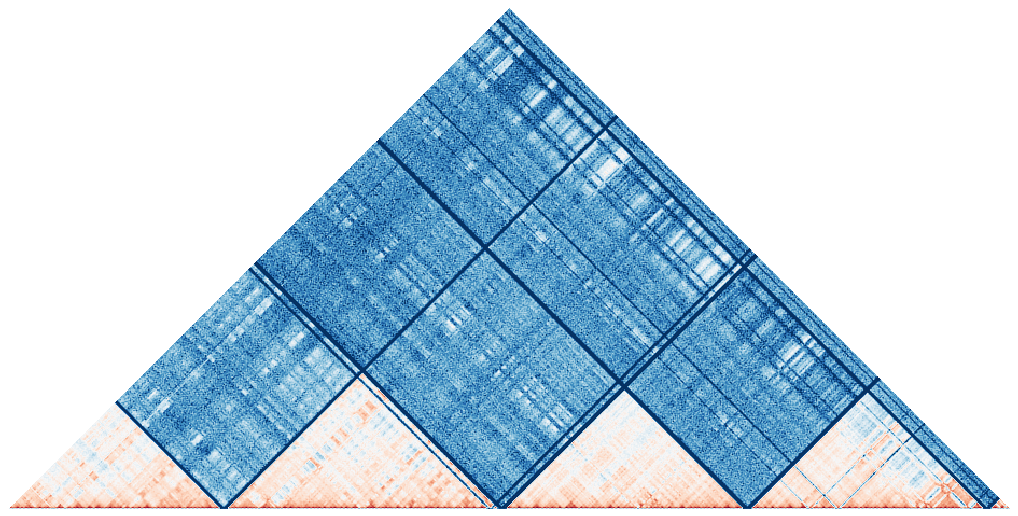

In [16]:
#large scale
pos = 155
st, fin = (pos-100, pos+560) # in bins

resolution = 1_000_000
file = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))[0]
cool = cooler.Cooler(file + "::/resolutions/%d" % resolution)

D = cool.matrix(balance=False)[:]
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom=='chr1'].index[0]

plot_hic(D, st, fin, profile=None, profnames=None, chrom_start=start, 
         savepath='figs/hic_pyramid_miniature_%d_interchromosomal.png' % resolution)

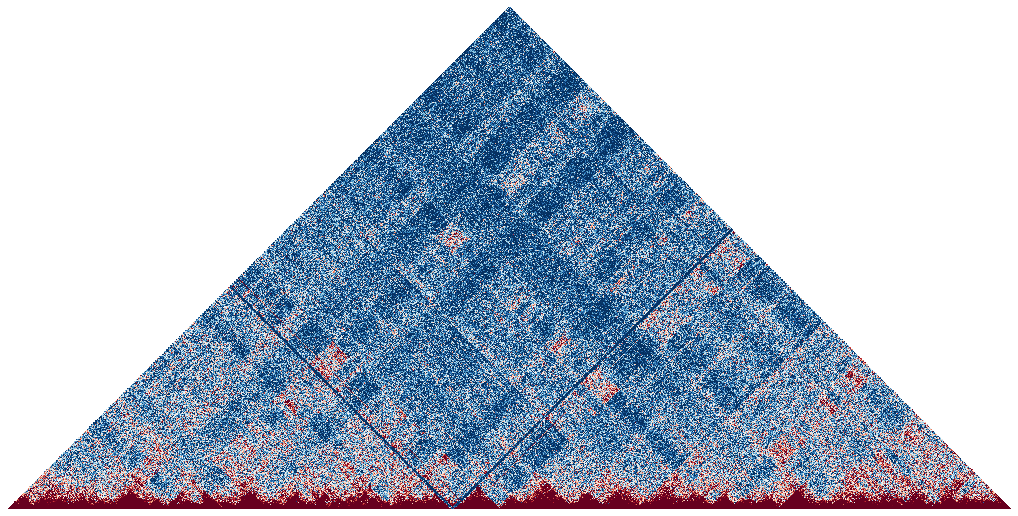

In [32]:
#chrom scale
pos = 155
st, fin = (pos-100, pos+1700) # in bins

resolution = 100_000
file = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))[0]
cool = cooler.Cooler(file + "::/resolutions/%d" % resolution)

D = cool.matrix(balance=False).fetch('chr1')
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom=='chr1'].index[0]

plot_hic(D, st, fin, profile=None, profnames=None, chrom_start=start, 
        savepath='figs/hic_pyramid_miniature_%d_chromosomal.png' % resolution, vmax=2)

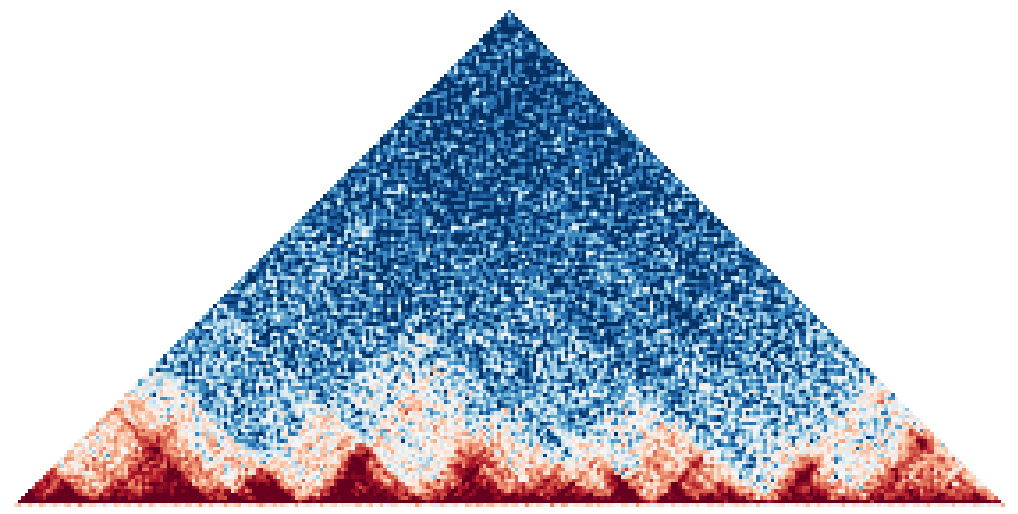

In [36]:
#medium scale
pos = 315
st, fin = (pos-100, pos+100) # in bins

resolution = 50_000
file = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))[0]
cool = cooler.Cooler(file + "::/resolutions/%d" % resolution)

D = cool.matrix(balance=False).fetch('chr1')
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom=='chr1'].index[0]

plot_hic(D, st, fin, profile=None, profnames=None, chrom_start=start, 
        savepath='figs/hic_pyramid_miniature_%d_medium.png' % resolution, vmax=5)

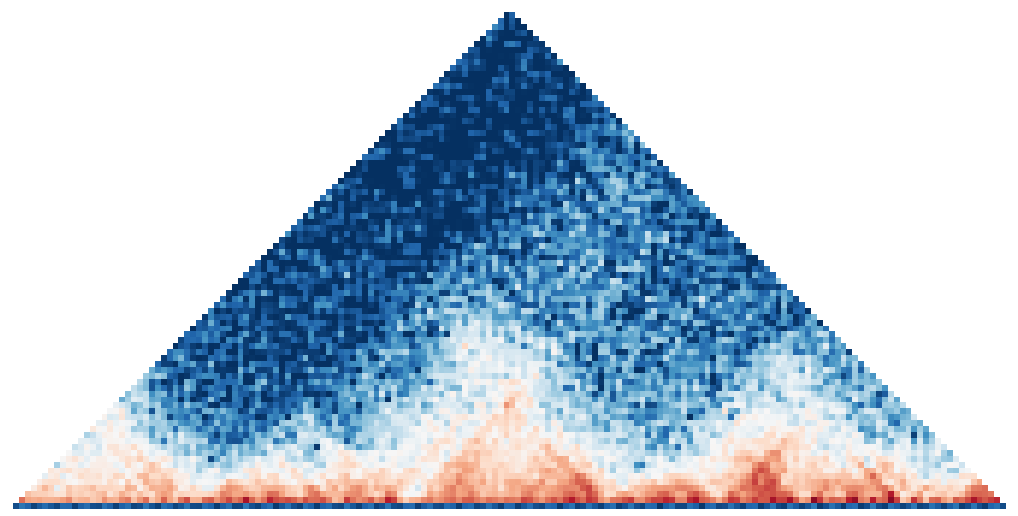

In [40]:
#point scale
pos = 710
st, fin = (pos-50, pos+50) # in bins

resolution = 50000
file = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))[0]
cool = cooler.Cooler(file + "::/resolutions/%d" % resolution)

D = cool.matrix(balance=False).fetch('chr1')
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom=='chr1'].index[0]

plot_hic(D, st, fin, profile=None, profnames=None, chrom_start=start, 
         savepath='figs/hic_pyramid_miniature_%d_res_point.png' % resolution)

# SCC

In [90]:
from hicrep.utils import readMcool
from hicrep import hicrepSCC
from itertools import combinations

binSize = 1_000_000 #put -1 if no .mcool
h = 1            # smoothing window half-size
dBPMax = 16_000_000 # maximal genomic distance to include in the calculation

# whether to perform down-sampling or not 
# if set True, it will bootstrap the data set # with larger contact counts to
# the same number of contacts as in the other data set; otherwise, the contact 
# matrices will be normalized by the respective total number of contacts
bDownSample = True

#paths = natsorted(glob(DOWNSAMPLED_FOLDER_PATH + '/*.cool'))
paths = FILES
# compute the SCC score
# this will result in a SCC score for each chromosome available in the data set
N = len(paths)
scc_matrix = np.zeros([N, N])
for i in tqdm(range(N)):
    for j in range(i, N):
        cool1, _ = readMcool(paths[i], binSize)
        cool2, _ = readMcool(paths[j], binSize)
        scc = hicrepSCC(cool1, cool2, h, dBPMax, bDownSample)
        scc_matrix[i,j] = np.nanmean(scc)
        scc_matrix[j,i] = np.nanmean(scc)

  0%|          | 0/12 [00:00<?, ?it/s]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/hicrep/hicrep.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return rhoNan2Zero @ wsNan2Zero / wsNan2Zero.sum()
100%|██████████| 12/12 [03:30<00:00, 17.53s/it]


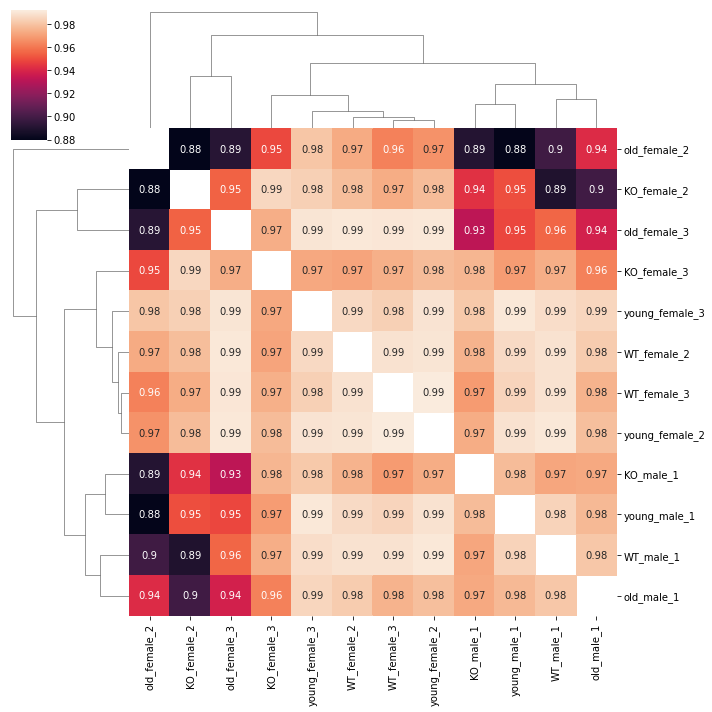

In [91]:
#add names
np.fill_diagonal(scc_matrix, 1)
scc_df = pd.DataFrame(scc_matrix, 
                      columns=[basename(path).split('.')[0] for path in paths],
                      index=[basename(path).split('.')[0] for path in paths])

sns.clustermap(scc_df, annot=True , mask=scc_df==1, method='complete')
#plt.savefig('./imgs/test.png', dpi=200)

# Scaling

In [63]:
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [64]:
#construct scalings
scalings_data = {}
for cond, clr in CLRS_DICT.items():
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    scalings_data[cond] = expected


In [65]:
#aggregate expected data
column = 'count.sum'
log = False
scale = 'mb'

agg_scaling = pd.DataFrame()
for k in scalings_data.keys():
    if column in ['count.sum', 'balanced.sum', 'balanced.avg.smoothed']:
        s = scalings_data[k].groupby('dist').mean()[column]
    else:
        raise NotImplementedError
    if log:
        s = np.log10(s)
    agg_scaling[k] = s

if scale == 'kb':
    agg_scaling.index = clr.info['bin-size'] * np.arange(agg_scaling.shape[0]) // 1000 
elif scale == 'mb':
    agg_scaling.index = clr.info['bin-size'] * np.arange(agg_scaling.shape[0]) / 1_000_000 

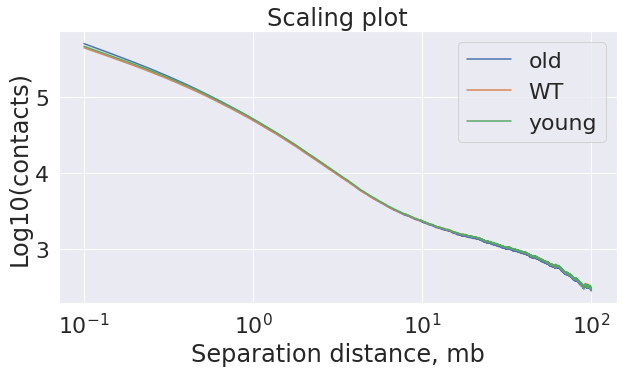

In [66]:
max_dist = 100
window = 20

profiles = ['old', 'WT', 'young']
plt.figure(figsize=(10,5))
plt.title('Scaling plot')
plt.xlabel(f'Separation distance, {scale}')
plt.ylabel(f'Log10(contacts)')
for p in profiles:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    s = np.log10(tmp[p])
    plt.semilogx(s, label = f'{p}', lw=1.5)
    #plt.plot(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.5)
plt.legend()
plt.savefig('figs/scaling.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

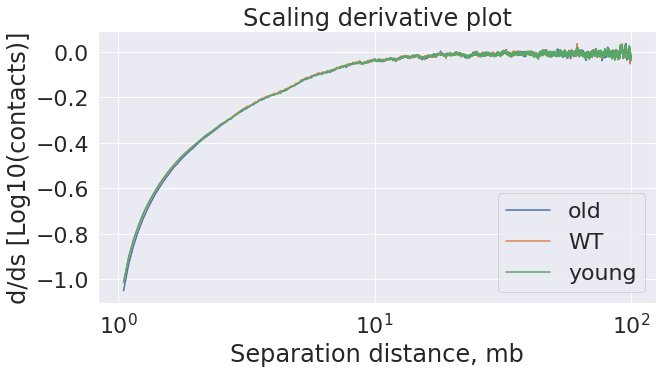

In [67]:
max_dist = 100
window = 20

profiles = ['old', 'WT', 'young']
plt.figure(figsize=(10,5))
plt.title('Scaling derivative plot')
plt.xlabel(f'Separation distance, {scale}')
plt.ylabel(f'd/ds [Log10(contacts)]')
for p in profiles:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    s = np.log10(tmp[p]).rolling(window = window).mean()
    sd = np.diff(s) / s.index[1]
    plt.semilogx(s.index[:-1], sd, label = f'{p}', lw=1.5)
    #plt.plot(s.index[:-1], sd, label = f'{p}', lw=1.5)
    #plt.plot(s)
    #plt.plot(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.5)
plt.legend()
plt.savefig('figs/scaling_derivative.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

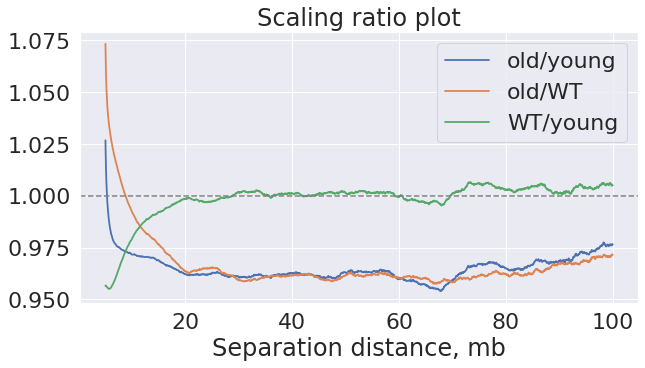

In [68]:
max_dist = 100
window = 100
pairs = [['old', 'young'], ['old', 'WT'], ['WT', 'young']]
plt.figure(figsize=(10,5))
plt.title('Scaling ratio plot')
plt.xlabel(f'Separation distance, {scale}')
for pair in pairs:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    #rel = tmp[pair[0]] / tmp[pair[1]]
    #smooth = rel.rolling(window = window).mean()
    smooth = tmp[pair[0]].rolling(window = window).mean() / tmp[pair[1]].rolling(window = window).mean()
    #plt.plot(rel, label = f'{pair[0]}/{pair[1]}', alpha=0.5, lw=0.7)
    plt.plot(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.8)
plt.axhline(y=1.0, ls='--', color='grey', lw=1.5)    
plt.legend()
plt.savefig('figs/scaling_ratio.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

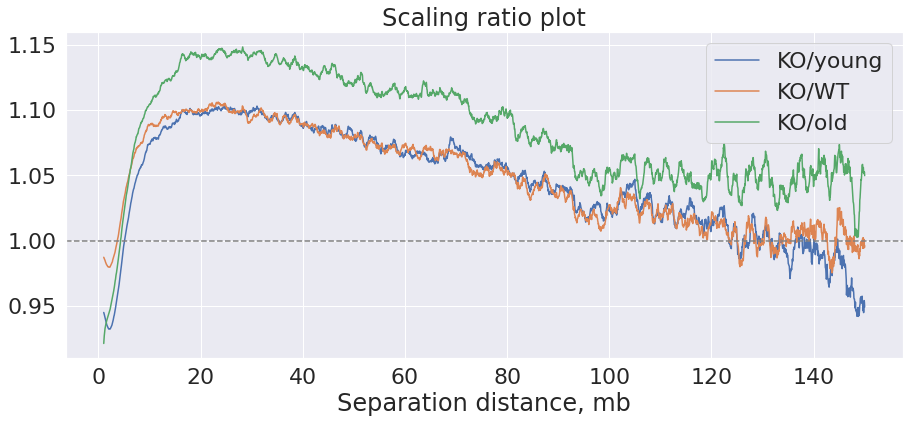

In [131]:
max_dist = 150
window = 20
pairs = [['KO', 'young'], ['KO', 'WT'], ['KO', 'old']]
plt.figure(figsize=(15,6))
plt.title('Scaling ratio plot')
plt.xlabel(f'Separation distance, {scale}')
for pair in pairs:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    rel = tmp[pair[0]] / tmp[pair[1]]
    smooth = rel.rolling(window = window).mean()
    #plt.plot(rel, label = f'{pair[0]}/{pair[1]}')
    plt.plot(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.5)
plt.axhline(y=1.0, ls='--', color='grey', lw=1.5)    
plt.legend()
plt.show()

# Intra/Interchromosomal interactions

In [4]:
def compute_cis_trans(hiclist, dropdiag=2, resolution=100000, stable=True, normalized=False):
    """
    This function returns a dictionary where keys are names of Hi-C matrices
    and values are matrices of cis-trans contact sums.
    
    hiclist :: [str] - list of paths to .mcool files
    dropdiag :: int - number of diags to drop (main diagonal counts from 1)
    resolution :: int - desired resolution for Hi-C matrix
    stable :: bool - whether to add 1 to contact sums matrix (for numerical 
                     stability at logarithm computation)
    normalized :: bool - whether to normalize matrix with a total sum of contacts
    """
    interchrom = {}
    for path in tqdm(hiclist):
        #clr = cooler.Cooler(path + '::/resolutions/%d' % resolution)
        clr = cooler.Cooler(path)
        sizes = np.array(clr.chromsizes.values) / resolution #compute normalization matrix
        norm = np.outer(sizes, sizes)

        pix = clr.pixels()[:]
        pix_no_diag = pix[pix.bin2_id >= pix.bin1_id + dropdiag] #delete m first diagonals
        bins = clr.bins()[:].drop(['start', 'end'], 1)

        cis_trans = np.asarray(
                    pix_no_diag.merge(bins, left_on='bin1_id', right_index=True).\
                                merge(bins, left_on='bin2_id', right_index=True).\
                                groupby(['chrom_x', 'chrom_y']).sum().\
                                unstack(fill_value=0)['count']) #convert to square matrix

        cis_trans = cis_trans + cis_trans.T - np.diag(np.diag(cis_trans))
        if normalized:
            fullsum = np.nansum(cis_trans)
            if fullsum == 0.:
                print('Drop %s due to zero contact sum' % path)
                continue
            cis_trans = cis_trans / fullsum * 2 * 1_000_000 #scale by constant
        if stable:
            cis_trans += 1
        result = cis_trans / norm
        interchrom[splitext(basename(clr.filename))[0]] = result
    return interchrom

In [5]:
interactions = compute_cis_trans(FILES, dropdiag=0, resolution=50000, stable=True, normalized=False)

100%|███████████████████████████████████████████████████████| 4/4 [02:12<00:00, 33.22s/it]


In [6]:
interactions = dict(zip([k.split('_')[1] for k in interactions.keys()], interactions.values()))
chroms = CLRS[0].chromnames

In [7]:
[(k, v.sum()) for k,v in interactions.items()]

[('KO', 51.7190138378333),
 ('WT', 52.229652566591696),
 ('old', 51.403358991520065),
 ('young', 52.04233557883741)]

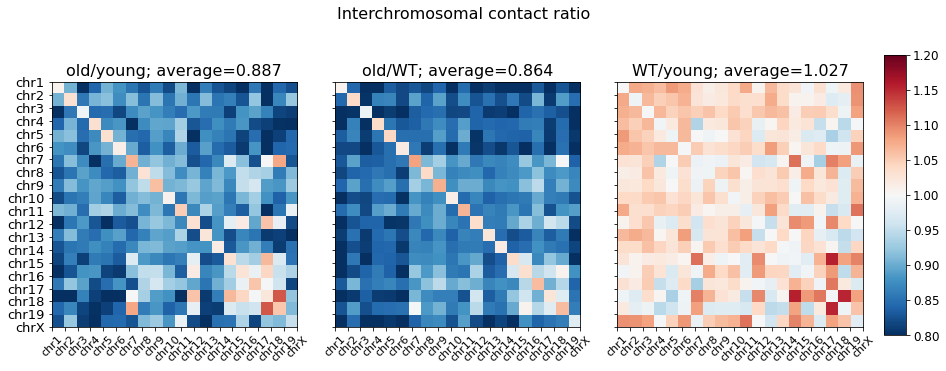

In [9]:
pairs = [('old', 'young'), ('old', 'WT'), ('WT', 'young')]
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True, sharex=True)
fig.suptitle('Interchromosomal contact ratio', fontsize=16, y=0.92, x=0.43)
fig.tight_layout(pad=3)
for k, ax, pair in zip(interactions.keys(), axes.flatten(), pairs):
    map1 = interactions[pair[0]][:-1, :-1]
    map2 = interactions[pair[1]][:-1, :-1]
    m = map1 / map2
    #np.fill_diagonal(m, np.nan)
    ax.set_title(pair[0] + '/' + pair[1] + '; average=%.3f' % np.nanmean(m), fontsize=16)
    im = ax.imshow(m, cmap='RdBu_r', vmax=1.2, vmin=0.8, extent=[-1,1,1,-1])
    ax.set_xticks(np.linspace(-1, 1, len(chroms[:-1])),)
    ax.set_yticks(np.linspace(-1, 1, len(chroms[:-1])),)
    ax.set_xticklabels(chroms[:-1], rotation=45, fontsize=11)
    ax.set_yticklabels(chroms[:-1], rotation=0, fontsize=13)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.16, 0.02, 0.65])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
plt.savefig('figs/interchromosomal_contact_ratio.pdf', dpi=300, bbox_inches='tight', format='pdf')

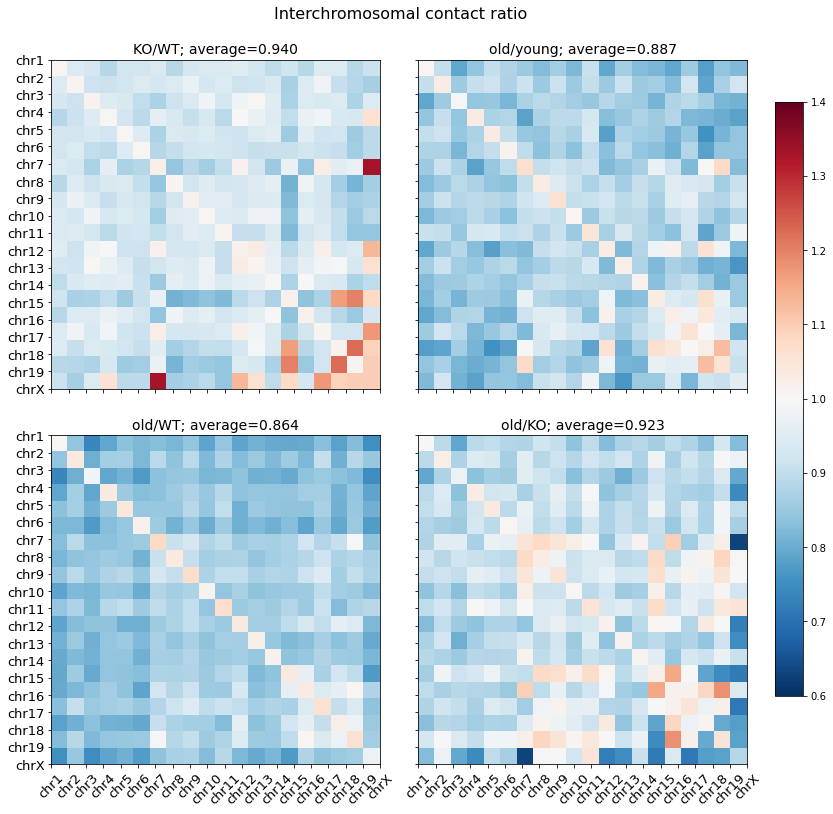

In [79]:
pairs = [('KO', 'WT'), ('old', 'young'), ('old', 'WT'), ('old', 'KO')]
fig, axes = plt.subplots(2, 2, figsize=(13, 11), sharey=True, sharex=True)
fig.suptitle('Interchromosomal contact ratio', fontsize=16, y=1.02, x=0.43)
fig.tight_layout(pad=3)
for k, ax, pair in zip(interactions.keys(), axes.flatten(), pairs):
    map1 = interactions[pair[0]][:-1, :-1]
    map2 = interactions[pair[1]][:-1, :-1]
    m = map1 / map2
    #np.fill_diagonal(m, np.nan)
    ax.set_title(pair[0] + '/' + pair[1] + '; average=%.3f' % np.nanmean(m), fontsize=14)
    im = ax.imshow(m, cmap='RdBu_r', vmax=1.4, vmin=0.6, extent=[-1,1,1,-1])
    ax.set_xticks(np.linspace(-1, 1, len(chroms[:-1])),)
    ax.set_yticks(np.linspace(-1, 1, len(chroms[:-1])),)
    ax.set_xticklabels(chroms[:-1], rotation=45, fontsize=13)
    ax.set_yticklabels(chroms[:-1], rotation=0, fontsize=13)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.75])
fig.colorbar(im, cax=cbar_ax)

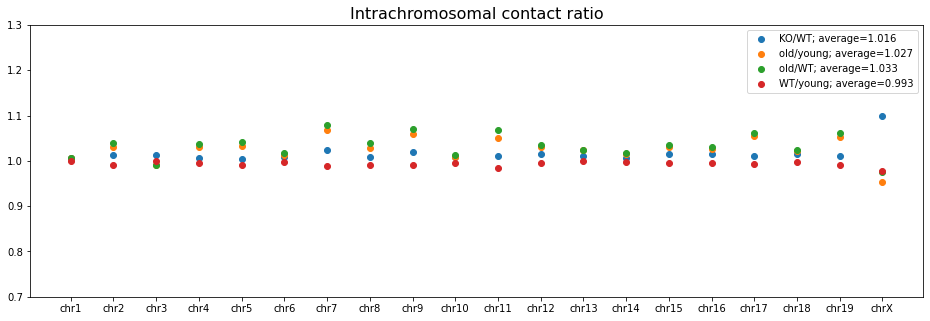

In [157]:
pairs = [('KO', 'WT'), ('old', 'young'), ('old', 'WT'), ('WT', 'young')]

plt.figure(figsize=(16,5))
plt.title('Intrachromosomal contact ratio', fontsize=16)
for k, ax, pair in zip(interactions.keys(), axes.flatten(), pairs):
    map1 = interactions[pair[0]][:-1, :-1].diagonal()
    map2 = interactions[pair[1]][:-1, :-1].diagonal()
    m = map1 / map2
    plt.scatter(chroms[:-1], m, label=pair[0] + '/' + pair[1] + '; average=%.3f' % np.nanmean(m))
plt.legend()
plt.ylim([0.7, 1.3])
plt.show()
    #ax.set_yticklabels(chroms[:-1], rotation=0)


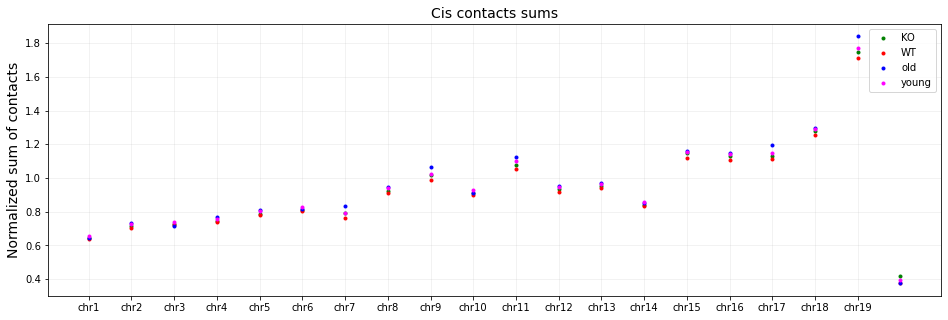

In [147]:
colors = ['green'] + ['red'] + ['blue'] + ['magenta']
#colors = ['red']*2 + ['green']*2

analysis_type = 'c' #c #t #ct

plt.figure(figsize=(16,5))
values = {}
for i, k in enumerate(list(interactions.keys())):
    map = interactions[k][:-1, :-1]
    if analysis_type == 'c':
        f = map.diagonal(0)
        plt.title('Cis contacts sums', fontsize=14)
    elif analysis_type == 't':
        f = (map.sum(1)- map.diagonal(0))
        plt.title('Trans contacts sums', fontsize=14)
    else:
        f = map.diagonal(0) / (map.sum(1) - map.diagonal(0))
        plt.title('Cis-trans ratio', fontsize=14)
    values[k] = f
    plt.plot(f, label=k, lw=0., marker='.', color=colors[i])
    #plt.ylim([0.2, 0.5])
plt.ylabel('Normalized sum of contacts', fontsize=14)
plt.xticks(ticks=range(len(chroms[:-2])), labels=chroms[:-2])
#plt.legend(['Old', 'Old', 'Young', 'Young'])
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Compartments

## eigvecs correlation

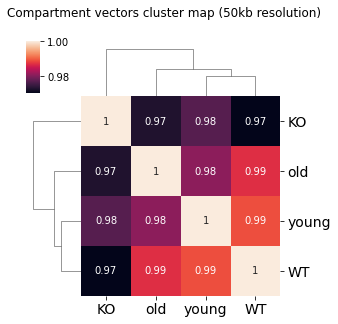

In [38]:
fix_chr = 'all' #'all' or chrom name
fix_row = 'best' #'best' or eigvec name
save = True

chroms = CLRS[0].chromnames
ignore_chroms = ['chrY']
keys = list(eigvec.keys())[::-1]

comp_df = pd.DataFrame()
coo = eigvec[keys[0]][~eigvec[keys[0]].chrom.isin(ignore_chroms)][['chrom', 'start', 'end']]
best_e_df = dict(zip(keys, [[] for _ in range(4)]))
for i, key in enumerate(keys):
    tmp = eigvec[key]
    if fix_chr == 'all':
        comp_vector = []
        for c in chroms:
            if c not in ignore_chroms:
                main_eigvec = 'E' + str(np.argmax(eigval[key].loc[c].filter(regex='eigval*'))+1)
                comp_vector.append(tmp[tmp.chrom==c][main_eigvec].to_numpy())
                best_e_df[key].append(main_eigvec)
        comp_df[key] = np.concatenate(comp_vector)
    elif (fix_chr != 'all') and (fix_row == 'best'):
        main_eigvec = 'E' + str(np.argmax(eigval[key].loc[fix_chr].filter(regex='eigval*'))+1)
        comp_vector = tmp[tmp.chrom==fix_chr][main_eigvec].to_numpy()
        comp_df[key] = comp_vector
    else:        
        comp_df[key] =  tmp[tmp['chrom']==fix_chr][fix_row]

if fix_chr == 'all':
    best_e_df = pd.DataFrame(best_e_df, index=chroms[:-1])#dataframe with best (by eigval) eigenvecs

ax = sns.clustermap(comp_df.corr(), annot=True, figsize=(4,4))
ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = 14)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_ymajorticklabels(), fontsize = 14, rotation=0)
ax.fig.suptitle('Compartment vectors cluster map (50kb resolution)', x=0.5, y=1.1)

comp_df_coo = pd.concat([coo, comp_df], axis=1)
if save:
    plt.savefig('./figs/compartments_cluster.pdf', dpi=300)
plt.show()

## pentads

In [45]:
from utils.pentads import *

max_zeros = 0.3
min_dimension = 5
distance_cutoff = 0.75
rescale_size = 33
balanced = False
plot = False

subplot_titles = ['Short-range A', 'Short-range B',
                  'Long-range A', 'Long-range B',
                  'Between A and B']
keys = list(eigvec.keys())
AVG_ALL = {}
for chrom in CLRS[0].chromnames[:-1]: #excluding Y chromosome
    print('Start %s' % chrom)
    AVG = {}
    for c, name in zip(CLRS, keys):    
        k = 0 #found compartments counter
        eigenvector = np.nan_to_num(comp_df_coo[comp_df_coo.chrom == chrom][name])
        #print(c, '\n', name, np.nan_to_num(np.asarray(eigenvector)))

        print('Processing cis data...' + name)
        average_compartment = [[], [], [], [], []] #container for average compartments
        areas_stats = [[0], [0], [0], [0], [0]]

        comp_A_index, comp_B_index, zero_bins = get_compartment_bins(eigenvector)
        intervals_A, intervals_B, intervals_zero = get_compartment_intervals(comp_A_index,
                                                                                 comp_B_index,
                                                                                 zero_bins)
        all_intervals = np.sort(intervals_A + intervals_B + intervals_zero)

        matrix = c.matrix(balance=balanced, sparse=True).fetch(chrom).toarray()
        matrix = np.nan_to_num(matrix)
        matrix, *other = numutils.observed_over_expected(matrix)

        for i in tqdm(range(0, len(all_intervals))): # iterate over interval indices
            for j in range(i, len(all_intervals)):
                area = get_area_from_matrix(matrix, all_intervals[i], all_intervals[j])

                if area_dimensions_are_large_enough(area, min_dimension) and\
                    area_has_enough_data(area, max_zeros) and\
                    area_is_close_enough(all_intervals[i], all_intervals[j],
                                         len(matrix), distance_cutoff):

                    area_resized = resize_area(area, rescale_size)
                    area_type = get_area_type(all_intervals[i], all_intervals[j],
                                              intervals_A, intervals_B)

                    k += 1
                    if (i == j):
                        if area_type == 'A':
                            average_compartment[0].append(area_resized)
                        elif area_type == 'B':
                            average_compartment[1].append(area_resized)
                    else:
                        if area_type == 'A':
                            average_compartment[2].append(area_resized)
                        elif area_type == 'B':
                            average_compartment[3].append(area_resized)
                        elif area_type == 'AB':
                            average_compartment[4].append(area_resized)

        for i in range(0, 5):
            areas_stats[i].append(len(average_compartment[i])-np.sum(areas_stats[i]))

        average_compartment = [np.nanmedian(x, axis = 0) for x in average_compartment]
        average_compartment = dict(zip(subplot_titles, average_compartment))
        print('Average compartment in cis calculated! Found %d compartment blocks' % k)
        print()
        AVG[name] = average_compartment
    AVG_ALL[chrom] = AVG
    vmin, vmax = get_comp_quantiles(AVG, 0.01, 0.99)
    print(vmin, vmax)
    if plot:
        plot_pentads_group(AVG, chrom, vmax, vmin, out_pref='figs/pentads/pentads_nonbal_%s' % chrom)

Start chr1
Processing cis data...KO


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/numpy/core/fromnumeric.py:997: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a).copy(order="K")
100%|██████████████████████████████████████████████████| 267/267 [00:00<00:00, 439.02it/s]


Average compartment in cis calculated! Found 257 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 287/287 [00:00<00:00, 425.32it/s]


Average compartment in cis calculated! Found 305 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 275/275 [00:00<00:00, 474.02it/s]


Average compartment in cis calculated! Found 310 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 290/290 [00:00<00:00, 424.01it/s]


Average compartment in cis calculated! Found 288 compartment blocks

0.5781112019938343 1.7718653657406795
Start chr2
Processing cis data...KO


100%|██████████████████████████████████████████████████| 258/258 [00:00<00:00, 395.23it/s]


Average compartment in cis calculated! Found 309 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 249/249 [00:00<00:00, 396.38it/s]


Average compartment in cis calculated! Found 334 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 251/251 [00:00<00:00, 384.20it/s]


Average compartment in cis calculated! Found 343 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 269/269 [00:00<00:00, 391.14it/s]


Average compartment in cis calculated! Found 324 compartment blocks

0.6676046259486244 1.8411081317611335
Start chr3
Processing cis data...KO


100%|██████████████████████████████████████████████████| 327/327 [00:00<00:00, 383.22it/s]


Average compartment in cis calculated! Found 371 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 314/314 [00:00<00:00, 379.56it/s]


Average compartment in cis calculated! Found 427 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 354/354 [00:00<00:00, 356.06it/s]


Average compartment in cis calculated! Found 491 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 367/367 [00:01<00:00, 354.66it/s]


Average compartment in cis calculated! Found 458 compartment blocks

0.6649713763461597 1.8332111807144584
Start chr4
Processing cis data...KO


100%|██████████████████████████████████████████████████| 152/152 [00:00<00:00, 600.79it/s]


Average compartment in cis calculated! Found 109 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 162/162 [00:00<00:00, 611.77it/s]


Average compartment in cis calculated! Found 154 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 158/158 [00:00<00:00, 537.15it/s]


Average compartment in cis calculated! Found 133 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 152/152 [00:00<00:00, 472.39it/s]


Average compartment in cis calculated! Found 117 compartment blocks

0.3116371042319825 2.5660585759741306
Start chr5
Processing cis data...KO


100%|██████████████████████████████████████████████████| 111/111 [00:00<00:00, 586.86it/s]


Average compartment in cis calculated! Found 103 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 128/128 [00:00<00:00, 640.12it/s]


Average compartment in cis calculated! Found 128 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 134/134 [00:00<00:00, 629.36it/s]


Average compartment in cis calculated! Found 134 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 132/132 [00:00<00:00, 708.53it/s]


Average compartment in cis calculated! Found 122 compartment blocks

0.5970662896663913 1.89636977627691
Start chr6
Processing cis data...KO


100%|██████████████████████████████████████████████████| 229/229 [00:00<00:00, 450.47it/s]


Average compartment in cis calculated! Found 189 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 184/184 [00:00<00:00, 542.46it/s]


Average compartment in cis calculated! Found 201 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 201/201 [00:00<00:00, 537.95it/s]


Average compartment in cis calculated! Found 229 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 205/205 [00:00<00:00, 552.41it/s]


Average compartment in cis calculated! Found 195 compartment blocks

0.6103064770447048 1.977608956938249
Start chr7
Processing cis data...KO


100%|██████████████████████████████████████████████████| 225/225 [00:00<00:00, 544.30it/s]


Average compartment in cis calculated! Found 263 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 244/244 [00:00<00:00, 506.12it/s]


Average compartment in cis calculated! Found 268 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 252/252 [00:00<00:00, 501.40it/s]


Average compartment in cis calculated! Found 319 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 237/237 [00:00<00:00, 551.08it/s]


Average compartment in cis calculated! Found 238 compartment blocks

0.45365493547608576 4.75295322017533
Start chr8
Processing cis data...KO


100%|██████████████████████████████████████████████████| 187/187 [00:00<00:00, 530.18it/s]


Average compartment in cis calculated! Found 168 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 173/173 [00:00<00:00, 676.83it/s]


Average compartment in cis calculated! Found 174 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 192/192 [00:00<00:00, 645.26it/s]


Average compartment in cis calculated! Found 203 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 177/177 [00:00<00:00, 617.27it/s]


Average compartment in cis calculated! Found 197 compartment blocks

0.5559426033929031 2.486672581010265
Start chr9
Processing cis data...KO


100%|██████████████████████████████████████████████████| 121/121 [00:00<00:00, 697.56it/s]


Average compartment in cis calculated! Found 147 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 107/107 [00:00<00:00, 722.38it/s]


Average compartment in cis calculated! Found 114 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 109/109 [00:00<00:00, 686.45it/s]


Average compartment in cis calculated! Found 132 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 103/103 [00:00<00:00, 707.65it/s]


Average compartment in cis calculated! Found 104 compartment blocks

0.4731016451494494 2.2899484468340874
Start chr10
Processing cis data...KO


100%|██████████████████████████████████████████████████| 201/201 [00:00<00:00, 588.66it/s]


Average compartment in cis calculated! Found 231 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 201/201 [00:00<00:00, 527.52it/s]


Average compartment in cis calculated! Found 222 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 197/197 [00:00<00:00, 584.47it/s]


Average compartment in cis calculated! Found 222 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 211/211 [00:00<00:00, 552.39it/s]


Average compartment in cis calculated! Found 235 compartment blocks

0.6380472379769845 1.8904873599165106
Start chr11
Processing cis data...KO


100%|██████████████████████████████████████████████████| 123/123 [00:00<00:00, 599.15it/s]


Average compartment in cis calculated! Found 125 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 117/117 [00:00<00:00, 606.15it/s]


Average compartment in cis calculated! Found 122 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 119/119 [00:00<00:00, 573.10it/s]


Average compartment in cis calculated! Found 126 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 113/113 [00:00<00:00, 568.26it/s]


Average compartment in cis calculated! Found 104 compartment blocks

0.43112343715756807 2.193695100771519
Start chr12
Processing cis data...KO


100%|██████████████████████████████████████████████████| 199/199 [00:00<00:00, 504.04it/s]


Average compartment in cis calculated! Found 250 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 208/208 [00:00<00:00, 501.12it/s]


Average compartment in cis calculated! Found 216 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 186/186 [00:00<00:00, 509.45it/s]


Average compartment in cis calculated! Found 253 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 207/207 [00:00<00:00, 501.18it/s]


Average compartment in cis calculated! Found 228 compartment blocks

0.633926933148751 2.6232538752327645
Start chr13
Processing cis data...KO


100%|██████████████████████████████████████████████████| 203/203 [00:00<00:00, 529.92it/s]


Average compartment in cis calculated! Found 117 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 157/157 [00:00<00:00, 554.77it/s]


Average compartment in cis calculated! Found 125 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 151/151 [00:00<00:00, 585.22it/s]


Average compartment in cis calculated! Found 139 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 180/180 [00:00<00:00, 544.57it/s]


Average compartment in cis calculated! Found 177 compartment blocks

0.40711096716304157 5.366960626891551
Start chr14
Processing cis data...KO


100%|██████████████████████████████████████████████████| 189/189 [00:00<00:00, 494.35it/s]


Average compartment in cis calculated! Found 212 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 181/181 [00:00<00:00, 507.60it/s]


Average compartment in cis calculated! Found 199 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 173/173 [00:00<00:00, 498.26it/s]


Average compartment in cis calculated! Found 242 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 180/180 [00:00<00:00, 542.86it/s]


Average compartment in cis calculated! Found 202 compartment blocks

0.5068429365191617 1.9282046642225619
Start chr15
Processing cis data...KO


100%|██████████████████████████████████████████████████| 157/157 [00:00<00:00, 572.45it/s]


Average compartment in cis calculated! Found 196 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 146/146 [00:00<00:00, 588.66it/s]


Average compartment in cis calculated! Found 171 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 155/155 [00:00<00:00, 591.03it/s]


Average compartment in cis calculated! Found 185 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 143/143 [00:00<00:00, 600.60it/s]


Average compartment in cis calculated! Found 182 compartment blocks

0.4971517303760251 1.92185053482253
Start chr16
Processing cis data...KO


100%|██████████████████████████████████████████████████| 119/119 [00:00<00:00, 716.77it/s]


Average compartment in cis calculated! Found 80 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 105/105 [00:00<00:00, 706.38it/s]


Average compartment in cis calculated! Found 94 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 105/105 [00:00<00:00, 700.65it/s]


Average compartment in cis calculated! Found 82 compartment blocks

Processing cis data...young


100%|████████████████████████████████████████████████████| 99/99 [00:00<00:00, 745.08it/s]


Average compartment in cis calculated! Found 72 compartment blocks

0.45489748285167375 4.981566362984752
Start chr17
Processing cis data...KO


100%|██████████████████████████████████████████████████| 129/129 [00:00<00:00, 706.60it/s]


Average compartment in cis calculated! Found 117 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 136/136 [00:00<00:00, 692.91it/s]


Average compartment in cis calculated! Found 129 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 155/155 [00:00<00:00, 656.01it/s]


Average compartment in cis calculated! Found 146 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 134/134 [00:00<00:00, 708.11it/s]


Average compartment in cis calculated! Found 100 compartment blocks

0.34255048208113514 2.3038338636249973
Start chr18
Processing cis data...KO


100%|██████████████████████████████████████████████████| 237/237 [00:00<00:00, 508.24it/s]


Average compartment in cis calculated! Found 317 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 216/216 [00:00<00:00, 532.39it/s]


Average compartment in cis calculated! Found 320 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 205/205 [00:00<00:00, 531.84it/s]


Average compartment in cis calculated! Found 370 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 245/245 [00:00<00:00, 504.34it/s]


Average compartment in cis calculated! Found 286 compartment blocks

0.6579292737235878 1.748355549809148
Start chr19
Processing cis data...KO


100%|████████████████████████████████████████████████████| 93/93 [00:00<00:00, 879.50it/s]

Average compartment in cis calculated! Found 114 compartment blocks

Processing cis data...WT



100%|██████████████████████████████████████████████████| 107/107 [00:00<00:00, 872.69it/s]


Average compartment in cis calculated! Found 109 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 117/117 [00:00<00:00, 788.73it/s]


Average compartment in cis calculated! Found 151 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 105/105 [00:00<00:00, 855.27it/s]


Average compartment in cis calculated! Found 119 compartment blocks

0.6115964433303126 2.8889940640500145
Start chrX
Processing cis data...KO


100%|██████████████████████████████████████████████████| 279/279 [00:00<00:00, 484.75it/s]


Average compartment in cis calculated! Found 197 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 255/255 [00:00<00:00, 482.26it/s]


Average compartment in cis calculated! Found 205 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 305/305 [00:00<00:00, 475.19it/s]


Average compartment in cis calculated! Found 170 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 210/210 [00:00<00:00, 589.71it/s]

Average compartment in cis calculated! Found 139 compartment blocks

0.5829809283671707 2.2387976663980824


In [96]:
#all chromosomes
chroms = CLRS[0].chromnames[:-1]
pairs = pairs = [['old', 'young'], ['old', 'WT'], ['WT', 'young'], ['KO', 'young'], ['KO', 'WT'], ['KO', 'old']]
AVG_pairs = {}
for pair in pairs:
    pairname = pair[0] + '/' + pair[1]
    AVG_pairs[pairname] = {}
    for sub in subplot_titles:
        x = []
        y = []
        for chrom in chroms:
            #x += AVG_ALL[chrom][pair[0]][sub]
            #y += AVG_ALL[chrom][pair[1]][sub]
            x.append(AVG_ALL[chrom][pair[0]][sub])
            y.append(AVG_ALL[chrom][pair[1]][sub])
        AVG_pairs[pairname][sub] = np.nanmedian(x, axis=0) / np.nanmedian(y, axis=0)
        
print(get_comp_quantiles(AVG_pairs, 0.01, 0.99))

(0.7313371885034002, 1.266992226027499)


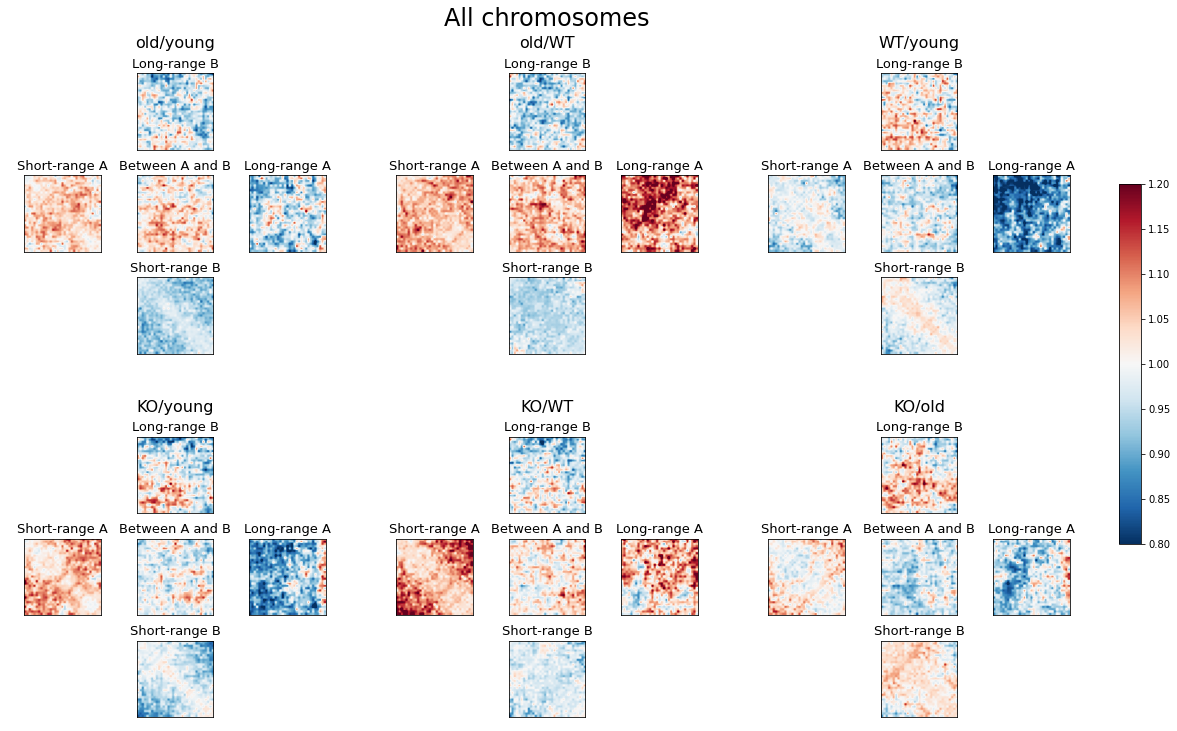

In [100]:
import matplotlib as mpl
subplot_titles = ['Short-range A', 'Short-range B',
                  'Long-range A', 'Long-range B',
                  'Between A and B']
subplot_indexes = [3, 7, 5, 1, 4]
vmin = 0.8
vmax = 1.2

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
fig.suptitle('All chromosomes', fontsize=24)

subfigs = fig.subfigures(2, 3, wspace=0.1, hspace=0.1)
for (name, average_compartment), subfig in zip(AVG_pairs.items(), subfigs.flat):
    title = name #subfigure title
    subfig.suptitle(title, fontsize=16)
    axs = subfig.subplots(3, 3).flatten()
    for subtitle, index in zip(subplot_titles, subplot_indexes):
        axs[index].set_title(subtitle, fontsize = 13)
        im = axs[index].imshow(average_compartment[subtitle], cmap = 'RdBu_r', vmin=vmin, vmax=vmax)
        axs[index].set_xticks([])
        axs[index].set_yticks([])
    for index in range(9): #erase 
        if index not in subplot_indexes:
            axs[index].set_visible(False)

cbar_ax = fig.add_axes([1.03, 0.25, 0.02, 0.5])
fig.colorbar(im, cax = cbar_ax)
plt.savefig(f'./figs/pentads_all.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

0.7457091605420191 1.2381298834105712


## LADs enrrichment

In [12]:
df_lad = pd.read_csv('./subdata/GSE17051_cLAD_mm10.bed', 
                     sep='\t', 
                     header=None).drop([3,4,5], axis=1)
df_lad.columns = ['Chromosome','Start','End']
df_lad['length'] = df_lad['End'] - df_lad['Start']
df_lad['log_length'] = np.log10(df_lad['length'])

df_lad_filt = df_lad[df_lad.length > 10_000] #filter those LAD domains which occupy more than 10kb 
lad_df = df_lad_filt[['Chromosome','Start','End']].copy()

In [19]:
#merge intervals
lad_pr = pr.PyRanges(lad_df)
bin_pr = comp_df_coo[['chrom', 'start', 'end']]
bin_pr.columns = ['Chromosome', 'Start', 'End']
bin_pr = pr.PyRanges(bin_pr)
result = bin_pr.join(lad_pr)
result = result.df

#bins in lads
#return compartments and DROP DUPLICATES !!!!
ldf = result.merge(comp_df_coo, left_on=['Chromosome','Start', 'End'], right_on=['chrom','start', 'end']).\
        drop(['chrom', 'start', 'end'], 1).drop_duplicates(subset=['Chromosome', 'Start', 'End'])

#bins not in LADs
nldf = comp_df_coo[comp_df_coo.merge(ldf, how='left', 
               left_on=['chrom', 'start', 'end'], 
               right_on=['Chromosome', 'Start', 'End'])['Chromosome'].isna().tolist()].dropna(0)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


In [20]:
from scipy.stats import chi2_contingency

factor = 'old'
cases = ['young', 'WT', 'old']

for factor in cases:
    A_LAD = (ldf[factor] > 0).sum()
    B_LAD = (ldf[factor] < 0).sum()
    A_nLAD = (nldf[factor] > 0).sum()
    B_nLAD = (nldf[factor] < 0).sum()

    cross_matrix = np.array([[A_LAD, A_nLAD], 
                             [B_LAD, B_nLAD]])

    chi, p, _, _ = chi2_contingency(cross_matrix)

    print('%s case: chi2 statistics = %.3f; p-value = %.5f' % (factor, chi, p))

young case: chi2 statistics = 13467.626; p-value = 0.00000
WT case: chi2 statistics = 14543.534; p-value = 0.00000
old case: chi2 statistics = 13532.611; p-value = 0.00000


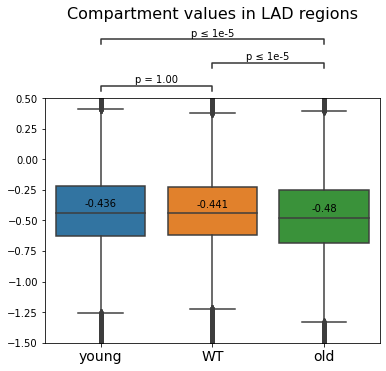

In [62]:
import warnings
warnings.filterwarnings('ignore')
from statannot import add_stat_annotation

labels = ['young', 'WT', 'old']
lad_oy = ldf[labels].dropna(0)
df = lad_oy.copy()

fig = plt.figure(figsize=(6,4.5))
fig.tight_layout(pad=5)
ax = sns.boxplot(data=df)
ax.set_title('Compartment values in LAD regions', loc="center", fontsize=16, y=1.3)
ax.set_xticklabels(labels, fontsize=14)
ax.set_ylim([-1.5,0.5])
test_results = add_stat_annotation(ax, data=df, 
                                   box_pairs=[ ("WT", "young"),
                                               ("old", "young"), 
                                               ("old", "WT"),
                                             ],
                                   test='Mann-Whitney', text_format='simple',
                                   loc='outside', verbose=0)
for i, c in enumerate(df.columns):
    ax.annotate(round(df[c].median(), 3), (i, df[c].median() + 0.05), ha='center')

plt.savefig('./figs/lad_compartments.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

# Insulation score analysis

In [4]:
from scipy.signal import argrelextrema
import scipy.optimize as optimization

explore = ['WT', 'young', 'old', 'KO']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
#X = X.dropna(axis=1)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


## Age dependence analysis

In [5]:
X = X.dropna(axis=1)

In [177]:
y = [4, 10, 20]
x_labels = ['young', 'WT', 'old']
y_dic = dict(zip(x_labels, y))

mask = np.array([any([e in c for e in x_labels]) for c in X.index])
X1 = X.loc[mask]
age = [y_dic[y] for y in [x.split('_')[0] for x in X1.index]]

import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from scipy.stats import pearsonr
pvals = []
coefs = []
for i in tqdm(range(X1.shape[1])):
    x = X1.iloc[: ,i]
#     X2 = sm.add_constant(x)
#     est = sm.OLS(age, X2)
#     est2 = est.fit()
#     res = est2.summary()
    r, p = pearsonr(x, age)
#     p = float(res.tables[1].data[2][4])
    pvals.append(p)
    coefs.append(r)

#model = ElasticNet()
#model.fit(X1, age)

100%|██████████| 42953/42953 [00:05<00:00, 7699.55it/s]


(array([2.0000e+00, 5.0000e+00, 1.9000e+01, 6.1000e+01, 1.9900e+02,
        5.8100e+02, 2.1140e+03, 6.1410e+03, 1.3242e+04, 2.0589e+04]),
 array([-5.25071925e+00, -4.72565544e+00, -4.20059163e+00, -3.67552782e+00,
        -3.15046401e+00, -2.62540020e+00, -2.10033639e+00, -1.57527258e+00,
        -1.05020877e+00, -5.25144961e-01, -8.11513498e-05]),
 <a list of 10 Patch objects>)

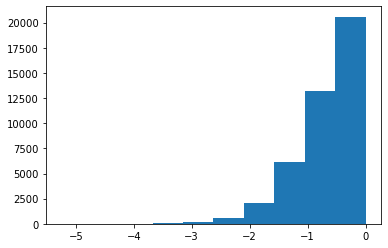

In [182]:
plt.hist(np.log10(pvals))

[0.7493108474554405,
 0.733576126102434,
 0.5754191113322994,
 0.4209875654787694,
 0.36465339028096705,
 0.3017419310912441,
 0.2752339789457133,
 0.2559911254749426,
 0.1311581342109487,
 0.23690627378239368,
 -0.06462124737979696,
 0.16770891476384236,
 0.046521489693522815,
 0.18810718656815653,
 0.09996865651707088,
 -0.05518631984592269,
 -0.5630990377824436,
 -0.4693983263575192,
 -0.5463927798793315,
 -0.4245681217862233,
 -0.14212748692659036,
 0.03813948374890373,
 0.2501492699441015,
 0.3985034779135772,
 0.4154319630130277,
 0.6786069218167993,
 0.6589514715741831,
 0.6172001641567515,
 0.5369736350356108,
 0.6070451115712505,
 0.5378262758356572,
 0.6433884124876709,
 0.6997720119712921,
 0.6069477075325399,
 0.45987747829175557,
 0.6322771261032224,
 0.565994603913158,
 0.41818331473714804,
 0.2697110172740341,
 0.12981784071709604,
 0.16776431784966214,
 0.05814452098128662,
 0.06619961068413215,
 -0.05932611744512982,
 -0.19432201288517484,
 -0.17846372183013273,
 -0.10

(array([ 483., 2941., 5594., 5697., 5019., 4575., 5114., 6810., 5537.,
        1183.]),
 array([-0.97737087, -0.78350638, -0.5896419 , -0.39577741, -0.20191292,
        -0.00804843,  0.18581606,  0.37968055,  0.57354503,  0.76740952,
         0.96127401]),
 <a list of 10 Patch objects>)

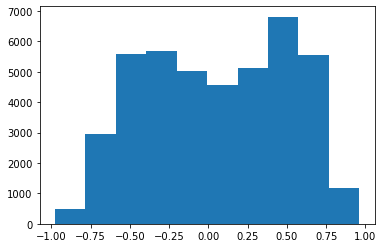

In [ ]:
plt.hist(coefs)

## TAD shift analysis

In [93]:
order = 5
indices = []
for i in range(X.shape[0]):
    row = X.iloc[i,:]
    s = np.array(row)
    lm = argrelextrema(s, np.less, order=order)[0]
    indices.append(row.iloc[lm].index)

result = sorted(list(set(indices[0]).intersection(*indices)))
border_dict = dict(zip(list(X.index), indices))

In [94]:
convex_dict = {}
for key in border_dict.keys():
    b = border_dict[key]
    convex_dict[key] = {}
    for i in range(b.shape[0]):
        x = np.arange(-order, order+1)
        v = X.loc[key, b[i]-order:b[i]+order] #vicinity of minimum
        y = v.to_numpy()

        def func(x, a):
            return a*(x**2) + y[y.shape[0]//2]

        params, _ = optimization.curve_fit(func, x, y)
        convex_dict[key][b[i]] = params.item()
    

# plt.scatter(x, y, marker='o', c='red')
# plt.plot(x, func(x, params), c='black')
# plt.show()

In [135]:
border_dict.keys()

dict_keys(['combined_KO_down_50000', 'combined_WT_down_50000', 'combined_old_down_50000', 'combined_young_down_50000'])

37449

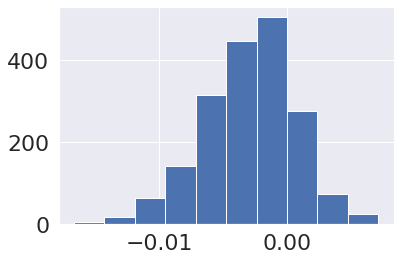

In [98]:
test = border_dict['combined_KO_down_50000'].intersection(border_dict['combined_WT_down_50000']).tolist()


diff = []
for t in test:
    d = convex_dict['combined_KO_down_50000'][t] - convex_dict['combined_WT_down_50000'][t]
    diff.append(d)

plt.hist(diff)
test[np.argmin(diff)]

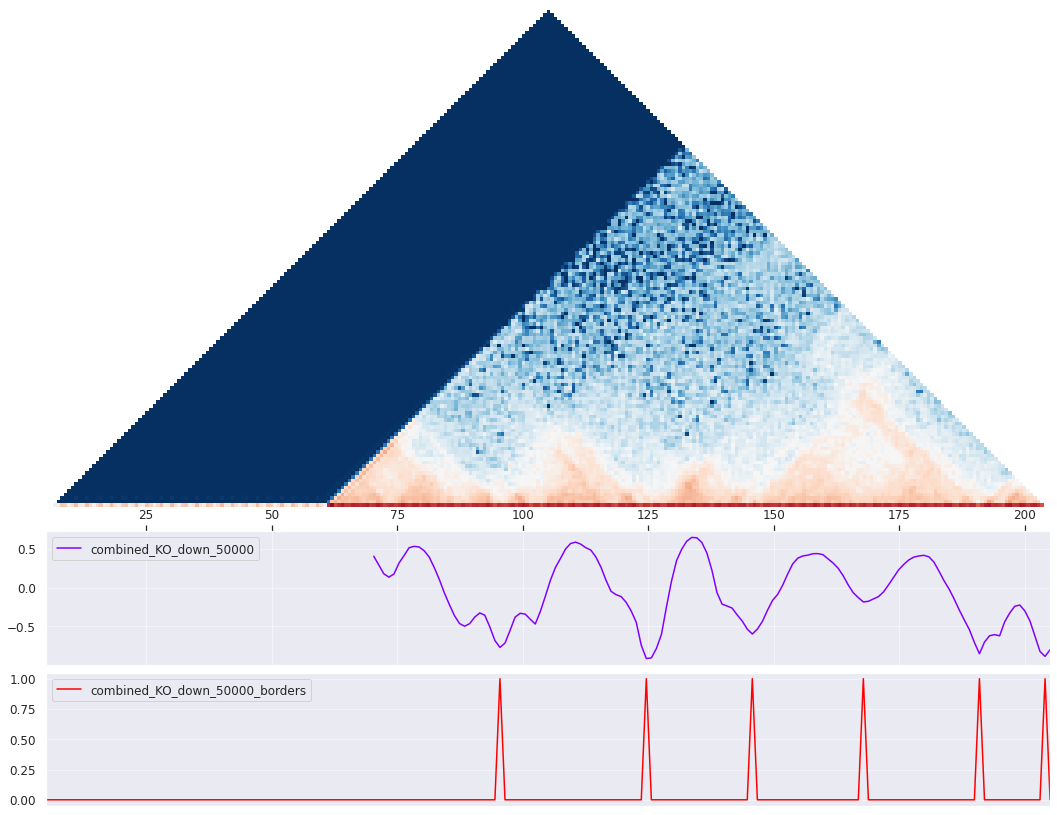

In [100]:
pos = 105
st, fin = (pos-100, pos+100) # in bins

rep = 'combined_KO_down_50000'

assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
chrom = IS.loc[st:fin].chrom.unique()[0]

#HI-C
cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
D = cool.matrix(balance=True).fetch(chrom)
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom==chrom].index[0]
#IS
profile = np.array(IS[rep])#.loc[st:fin-1])
#TAD BORDERS
borders_plot = np.zeros(profile.shape)
for idx in border_dict[rep]:
    borders_plot[idx] += 1

plot_hic(D, st, fin, profile=[profile, borders_plot], 
                         profnames=[rep, rep + '_borders'], chrom_start=start)

In [15]:
# rep = 'young_male_1'

# assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
# chrom = IS.loc[st:fin].chrom.unique()[0]

# #HI-C
# cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
# D = cool.matrix(balance=True).fetch(chrom)
# D = mylog(D, log=True)
# bins = cool.bins()[:]
# start = bins[bins.chrom==chrom].index[0]
# #IS
# profile = np.array(IS[rep])#.loc[st:fin-1])
# #TAD BORDERS
# borders_plot = np.zeros(profile.shape)
# for idx in border_dict[rep]:
#     borders_plot[idx] += 1

# plot_hic(D, st, fin, profile=[profile, borders_plot], 
#                          profnames=[rep, rep + '_borders'], chrom_start=start)

## insulation peaks fold change

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KO v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.040e-04 U_stat=6.462e+06
old v.s. young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.111e+06
WT v.s. young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.029e+06
KO v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.092e-03 U_stat=6.379e+06


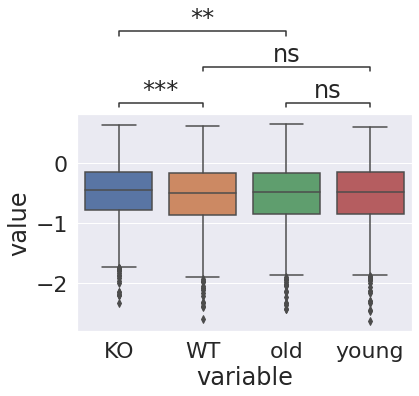

In [184]:
from functools import reduce
union = reduce(pd.Index.union, border_dict.values())

bpeaks = IS.loc[union]
tmp = pd.melt(bpeaks.iloc[:, 1:5])
tmp['variable'] = tmp['variable'].apply(lambda x: x.split('_')[1])
#for pair in 
#d = bpeaks.filter(regex='KO').iloc[:, 0] - bpeaks.filter(regex='WT').iloc[:, 0]
#d.plot(kind='kde')

from statannot import add_stat_annotation

df = sns.load_dataset("tips")
x = "variable"
y = "value"
order = ['KO', 'WT', 'old', 'young']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("KO", "WT"), ("old", "young"), ("WT", "young"), ("KO", "old")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

# interTADs

In [5]:
#coolpuppy API
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [23]:
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)
mm10_arms = mm10_arms.set_index("chrom")

In [24]:
mm10_chromsizes.to_csv('/tank/projects/kriukov_chromatin/GENOME/chrfile.txt', sep='\t')
mm10_arms.to_csv('/tank/projects/kriukov_chromatin/GENOME/chrom_arms.txt', sep='\t')

In [107]:
#construct average interTADs
pup = pd.DataFrame()
cond = [basename(c.filename).split('_')[1] for c in CLRS]
for k, v in border_dict.items():
    clr = [c for c in CLRS if c.filename.__contains__(k)][0]
    name = splitext(basename(clr.filename))[0]
    sites = IS.loc[v.tolist(),['chrom', 'start', 'end']].reset_index(drop=True)
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    #calculate mean interTADs
    cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                              features_format='bed', local=True, flank=1_000_000)
    pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=mm10_arms, ignore_diags=0)
    pup = pup.append(pu.pileupsWithControl(nproc=18))
pup['condition'] = cond
#pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

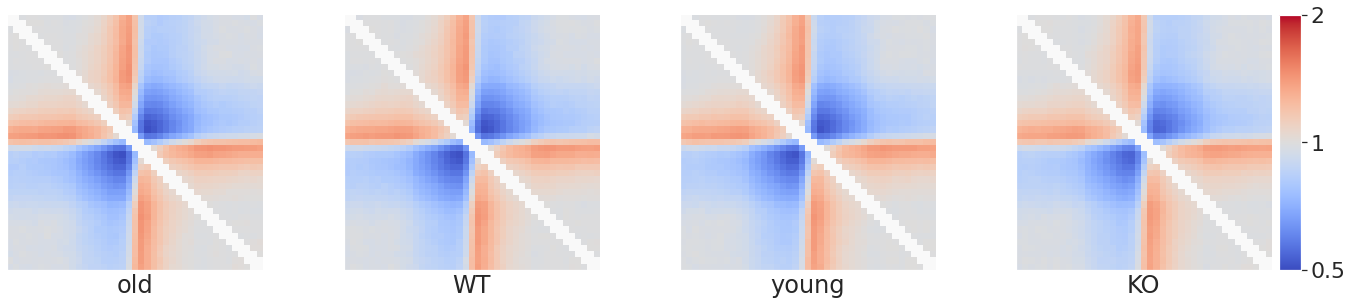

In [114]:
plotpup.make_heatmap_grid(pup,
                          #rows='condition', #col_order=['--', '++'],
                          cols='condition',
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)

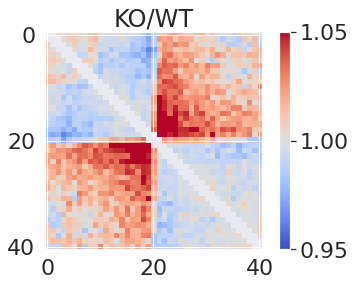

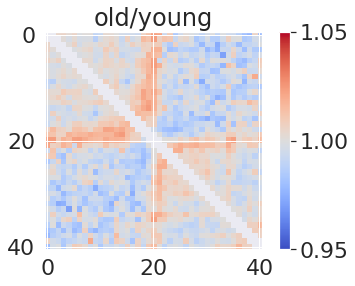

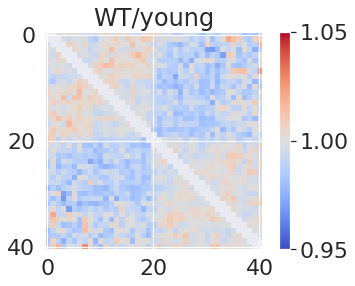

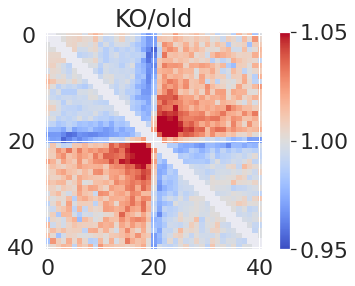

In [122]:
pairs = [['KO', 'WT'], ['old', 'young'], ['WT', 'young'], ['KO', 'old']]
for pair in pairs:
    divv = pup[pup.condition==pair[0]]['data'][0] / pup[pup.condition==pair[1]]['data'][0]
    plt.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.05, vmin=0.95)
    plt.title('%s/%s' % (pair[0], pair[1]))
    plt.colorbar()
    plt.show()

# TADs

## plot TADs

In [5]:
#!pip install git+https://github.com/nvictus/lavaburst.git

#import lavaburst

#coolpuppy API
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [6]:
#construct average TADs
ids_10k = cooler.Cooler(DOWNSAMPLED_FOLDER_PATH + '/merged/combined_KO_down_10000.cool').bins()[:]
base_expected = False #CLRS_DICT['WT']
minimal_tad_size = 50_000
maximal_tad_size = 1_000_000 #np.inf

pup = pd.DataFrame()
for cond, clr in CLRS_DICT.items():
    name = splitext(basename(clr.filename))[0]
    #gather tad coordinates
    tad_name = [c for c in list(TADS.keys()) if c.__contains__(cond)][0]
    tads = TADS[tad_name]
    sites = pd.DataFrame()
    for chrom in tads.keys():
        tads[chrom]
        for t in tads[chrom]:
            st = ids_10k[ids_10k['chrom']==chrom].iloc[t[0]]['start']
            en = ids_10k[ids_10k['chrom']==chrom].iloc[t[1]]['end']
            sites = sites.append({'chrom':chrom, 'start':st, 'end':en}, ignore_index=True)
    sites['start'] = sites['start'].astype(int)
    sites['end'] = sites['end'].astype(int)
    #sites = sites.head(1)
    sites = sites[((sites['end'] - sites['start']) > minimal_tad_size) &\
                  ((sites['end'] - sites['start']) < maximal_tad_size)]
    # Calculate expected interactions for chromosome arms
    if base_expected:
        expected = expected_cis(base_expected, view_df=mm10_arms, chunksize=1000000, nproc=18)
    else:
        expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    #calculate mean interTADs
    cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                              features_format='bed', local=True, rescale_flank=0.5)
    pu = coolpup.PileUpper(clr, cc, 
                           expected=expected, 
                           rescale=True,
                           view_df=mm10_arms, ignore_diags=0)
    pup = pup.append(pu.pileupsWithControl(nproc=18))
pup['condition'] = CLRS_DICT.keys()


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Ignoring flank in favor of rescale_flank = 0.5


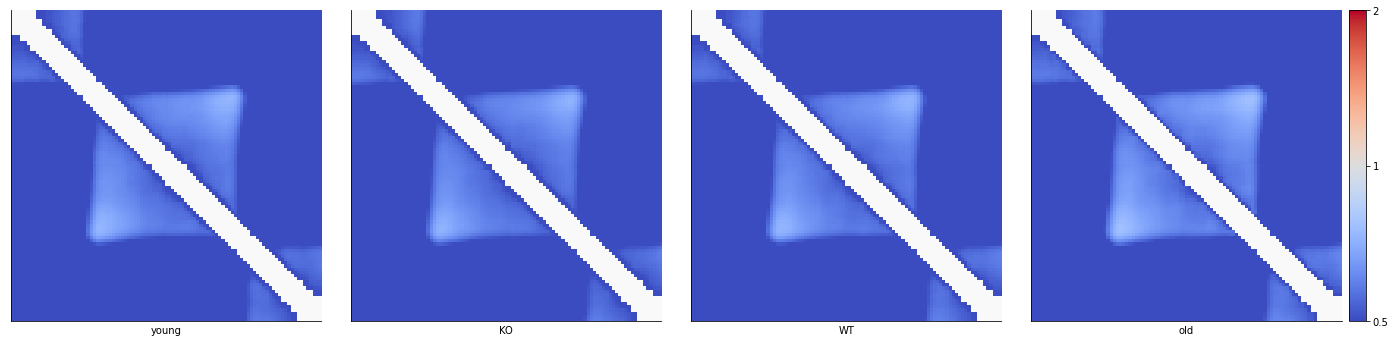

In [7]:
plotpup.make_heatmap_grid(pup,
                          #rows='condition', #col_order=['--', '++'],
                          cols='condition',
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


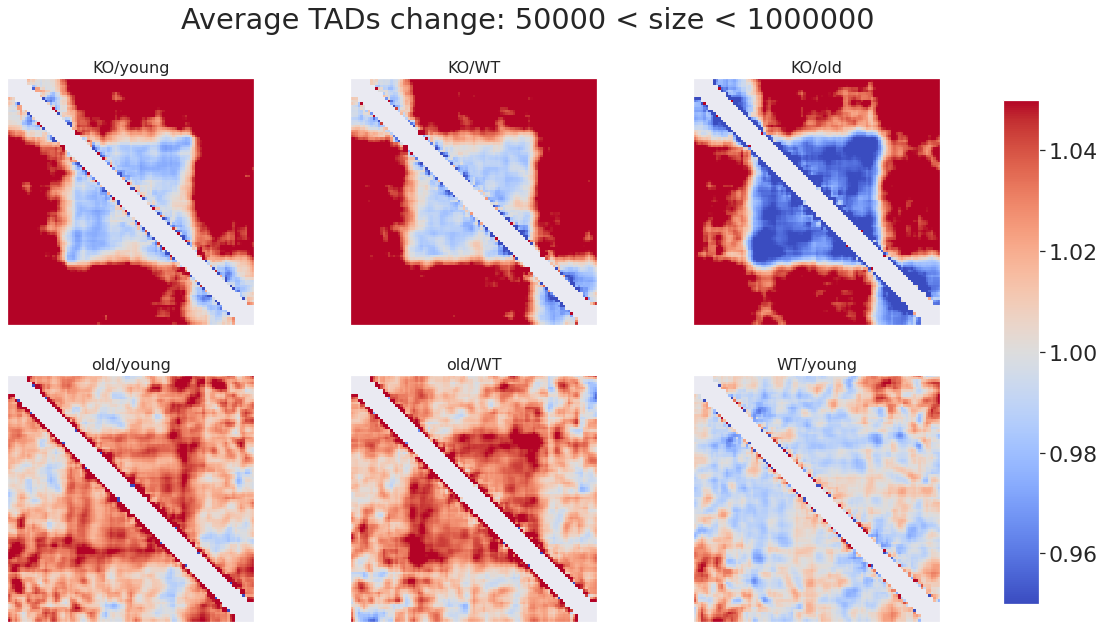

In [11]:
sns.set_theme(font_scale=2)
pairs = [['KO', 'young'], ['KO', 'WT'], ['KO', 'old'], ['old', 'young'], ['old', 'WT'], ['WT', 'young']]

fig, axes = plt.subplots(2, round(len(pairs)/2), figsize=(5 * (len(pairs)//2 + 1), 10), sharex=True, sharey=True)
fig.suptitle(f'Average TADs change: {minimal_tad_size} < size < {maximal_tad_size}')
for pair, ax in zip(pairs, axes.flatten()):
    divv = pup[pup.condition==pair[0]]['data'][0] / pup[pup.condition==pair[1]]['data'][0]
    img = ax.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.05, vmin=0.95)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('%s/%s' % (pair[0], pair[1]), fontsize=16)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.025, 0.7])
fig.colorbar(img, cax=cbar_ax)
if len(pairs) % 2 != 0: #remove redundant axis
    axes.flatten()[-1].set_axis_off()
plt.savefig(f'./figs/avg_TAD_{minimal_tad_size}<size<{maximal_tad_size}.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
####plot average TADs by IS
# #construct average TADs
# pup = pd.DataFrame()
# cond = [basename(c.filename).split('_')[0] for c in CLRS]
# for k, v in border_dict.items():
#     clr = [c for c in CLRS if c.filename.__contains__(k)][0]
#     name = splitext(basename(clr.filename))[0]
#     #assumption: TADs are not intermittent
#     sites = IS.loc[v.tolist(),['chrom', 'start', 'end']].reset_index(drop=True)
#     sites['end'] = np.roll(sites['end'], -1)
#     sites = sites[:-1]
#     #sites = sites.head(1)
#     # Calculate expected interactions for chromosome arms
#     expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
#     #calculate mean interTADs
#     cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
#                               features_format='bed', local=True, flank=1_000_000)
#     pu = coolpup.PileUpper(clr, cc, 
#                            #expected=expected, 
#                            rescale=True,
#                            view_df=mm10_arms, ignore_diags=0)
#     pup = pup.append(pu.pileupsWithControl(nproc=18))
# pup['condition'] = cond
# pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

# Loops

In [30]:
import os
#Run loops finding
min_dist = 350_000
max_dist = 3_500_000
pearson = 0.45
for clr in tqdm(CLRS):    
    cool = clr.filename
    prefix = LOOP_PATH + '/' + splitext(basename(cool))[0]
    command = f"chromosight detect --threads 24 \
        --min-dist {min_dist} --max-dist {max_dist} --pearson {pearson} \
        {cool} {prefix}"
    os.system(command)


  0%|                                                               | 0/4 [00:00<?, ?it/s]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Found 49386 / 54520 detectable bins
Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0
2967 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.pdf


Minimum pattern separation is : 1


 25%|█████████████▊                                         | 1/4 [00:13<00:39, 13.27s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Found 49462 / 54520 detectable bins
Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


3068 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_50000.pdf
 50%|███████████████████████████▌                           | 2/4 [00:26<00:26, 13.35s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Found 49762 / 54520 detectable bins
Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0
3099 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_50000.pdf


Minimum pattern separation is : 1


 75%|█████████████████████████████████████████▎             | 3/4 [00:39<00:13, 13.02s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Found 49449 / 54520 detectable bins
Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


3077 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_50000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_50000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_50000.pdf
100%|███████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.11s/it]


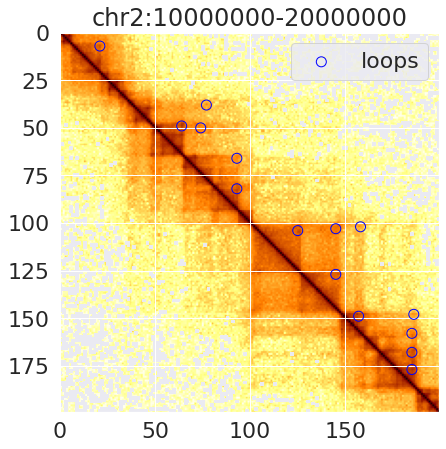

In [12]:
#look at them
import re
import json
import numpy as np
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import chromosight.utils.detection as cud

loops = pd.read_csv('/tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_50000.tsv', sep='\t')
c = cooler.Cooler("/tank/projects/kriukov_chromatin/HIC/downsampled/merged/combined_KO_down_50000.cool")

def subset_region(df, region):
    """
    Given a pattern dataframe and UCSC region string, retrieve only patterns in that region.
    """
    # Split the region string at each occurence of - or : (yields 3 elements)
    chrom, start, end = re.split('[-:]', region)
    start, end = int(start), int(end)
    # Only keep patterns on the same chromosome as the region and
    # within the start-end interval
    subset = df.loc[
        (df.chrom1 == chrom) &
        (df.chrom2 == chrom) &
        (df.start1 >= start) &
        (df.start2 >= start) &
        (df.end1 < end) &
        (df.end2 < end), :
    ]
    return subset

# Select a region of interest

start = 10000000
#region = 'chr2:%d-%d' % (start, start + 3000000)
region = 'chr2:%d-%d' % (start, start + 10_000_000)
mat = c.matrix(sparse=False, balance=True).fetch(region)


loops_sub = subset_region(loops, region)
#borders_sub = subset_region(borders, region)
#hairpins_sub = subset_region(hairpins, region)

# Make genome-based bin numbers relative to the region
for df in [loops_sub]:#, borders_sub, hairpins_sub]:
    df.bin1 -= c.extent(region)[0]
    df.bin2 -= c.extent(region)[0]

plt.figure(figsize=(7, 7))
plt.imshow(np.log10(mat), cmap='afmhot_r')
plt.title(region)
plt.scatter(loops_sub.bin2, loops_sub.bin1, edgecolors='blue', facecolors='none', label='loops', s=100)
#plt.scatter(borders_sub.bin2, borders_sub.bin1, c='lightblue', label='borders')
#plt.scatter(hairpins_sub.bin2, hairpins_sub.bin1, c='green', label='hairpins')
plt.legend()
plt.savefig('./figs/loops_example.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
#(loops['start2'] - loops['start1']).hist()

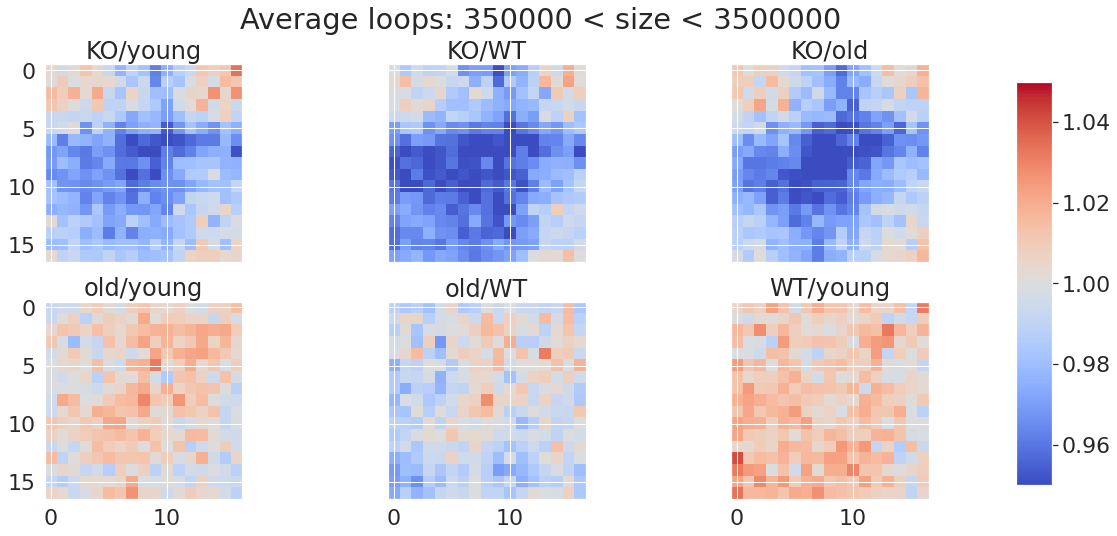

In [13]:
#compare between conditions
min_dist = 350_000
max_dist = 3_500_000
LOOPS_WIN_FILES = glob('/tank/projects/kriukov_chromatin/HIC/loops/*_50000.json')

average_loops = {}
for loop_file in LOOPS_WIN_FILES:
    # Load input json file into a dictionary
    loop_wins = json.load(open(loop_file, 'r'))
    # Note that keys are string, as required by the JSON format,
    # so we convert them to int() for convenience
    loop_wins = {int(i): np.array(w) for i, w in loop_wins.items()}
    # Make an empty 3D array of shape N_coords x height x width
    wins = np.zeros((len(loop_wins.items()), *loop_wins[0].shape))
    # Fill the 3D array with windows values
    for i, w in loop_wins.items(): wins[i] = w
    pileup = cud.pileup_patterns(wins)
    name = splitext(basename(loop_file))[0].split('_')[1]
    average_loops[name] = pileup


pairs = [['KO', 'young'], ['KO', 'WT'], ['KO', 'old'], ['old', 'young'], ['old', 'WT'], ['WT', 'young']]
fig, axes = plt.subplots(2, round(len(pairs)/2), figsize=(5 * (len(pairs)//2 + 1), 8), sharex=True, sharey=True)
fig.suptitle(f'Average loops: {min_dist} < size < {max_dist}')

for pair, ax in zip(pairs, axes.flatten()):
    divv = average_loops[pair[0]] / average_loops[pair[1]]
    img = ax.imshow(divv, cmap='coolwarm', vmax=1.05, vmin=0.95)
    ax.set_title(f'{pair[0]}/{pair[1]}')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.025, 0.7])
fig.colorbar(img, cax=cbar_ax)
if len(pairs) % 2 != 0: #remove redundant axis
    axes.flatten()[-1].set_axis_off()
    
plt.savefig('./figs/loops_avg_changes.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()



# ANOVA analysis

In [21]:
explore = ['WT', 'young', 'old']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
X = X.dropna(axis=1)

y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex

types_dict = {'WT':'Y', 'young':'Y', 'old':'old'}
y = [types_dict[t] for t in y]
print(y)

['Y', 'Y', 'Y', 'old', 'old', 'old', 'Y', 'Y', 'Y']


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


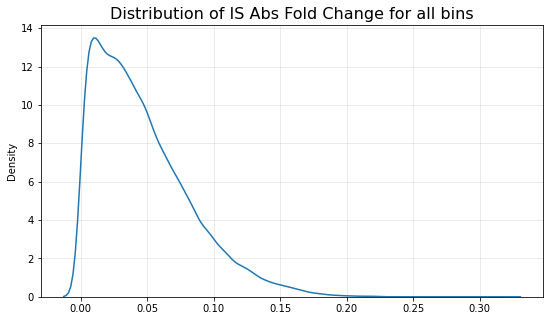

Total number of features: 42953
Number of p_values <= 0.050: 11162
Number of p_values after FDR correction: 4


14282     14283     14284     35648
WT_female_2     0.444180  0.413791  0.379288 -0.265062
WT_female_3     0.434824  0.409935  0.391529 -0.276402
WT_male_1       0.431056  0.433262  0.423213 -0.249603
old_female_2    0.528548  0.539883  0.520195 -0.067546
old_female_3    0.516813  0.534430  0.513157 -0.106329
old_male_1      0.532389  0.524549  0.528388 -0.079973
young_female_2  0.429855  0.425943  0.393686 -0.286080
young_female_3  0.435138  0.423855  0.405221 -0.250814
young_male_1    0.414353  0.417796  0.401963 -0.292838

In [22]:
anova = ANOVA(X, y, 0.05)
anova.get_filter_distribution('FC')

a, b = anova.make_anova()
anova.get_passed_features()

100%|█████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.19it/s]


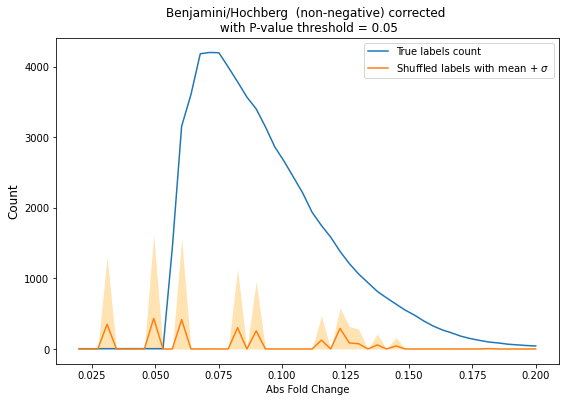

0.07142857142857144

In [23]:
anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
anova.plot_permutation_results()
anova.get_best_criterion()

In [24]:
X_s, FDR, Pval = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
                                                        return_pvals=True)
P_adj_s_sorted = np.sort(FDR[1][FDR[0]])
X_s_sorted = X_s.iloc[:, np.argsort(FDR[1][FDR[0]])]

order = ['old', 'Y']
X_group = X_s_sorted.groupby(y).mean()
X_diff = X_group.loc[order[0]] - X_group.loc[order[1]]
#extract intervals and p_values, take top N bins
X_passed_intervals = IS.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
X_passed_intervals['pval'] = Pval[FDR[0]]
X_passed_intervals['p_adj'] = P_adj_s_sorted
X_passed_intervals['FC'] = X_diff

print("Bins passed: %d" % X_passed_intervals.shape[0])

Bins passed: 4202


In [27]:
top = max(500, X_passed_intervals.shape[0])
X_top = X_passed_intervals.sort_values('pval').iloc[:top, :]

#intersection with genes
significant_genes = bins_to_genes_intersection(X_top[['chrom', 'start', 'end']], gn_code)

In [28]:
genesFC = significant_genes.merge(X_top, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

gmean = lambda x: np.exp(np.mean(np.log(x)))
agg = genesFC.groupby(['Name']).agg({'Start':'first','End':'first', 
                                     'Start_b':'first', 'End_b':'last', 
                                     'pval':gmean, 'FC':'mean'})
agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
agg['ES'] = -np.log10(agg['pval']) * agg['FC']

In [29]:
agg.to_csv('subdata/IS_results.csv')

In [136]:
#Assumptions:
# - Equal variances (sample sizes)
# - Normal distribution of population
# - Independence
EXPLORES = [['old', 'young'], ['KO', 'young'], ['WT', 'young'], ['KO', 'WT'], ['old', 'WT']]
gmean = lambda x: np.exp(np.mean(np.log(x)))

for explore in tqdm(EXPLORES):
    ### Data filtering
    fname = '::'.join(explore)
    mask = np.array([any([e in c for e in explore]) for c in IS.columns])
    X = IS.drop(IS.columns[~mask], 1).T
    X = X.dropna(axis=1)
    y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex
    
    ### ANOVA
    anova = ANOVA(X, y, 0.02)
    p, pcor = anova.make_anova()
    X_group = X.groupby(y).mean()
    X_diff = X_group.loc[explore[0]] - X_group.loc[explore[1]]
    #extract intervals and p_values, take top N bins
    X_passed_intervals = IS.loc[X.columns][['chrom', 'start', 'end']]
    X_passed_intervals['pval'] = p
    X_passed_intervals['FC'] = X_diff
   
    # #anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
    # X_s, P_s = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
    #                                                         return_pvals=True)
    # #plot
    # #anova.plot_permutation_results(savename='Insulation/' + fname + '_FC.png')
    
    # P_adj_s_sorted = np.sort(P_s[1][P_s[0]])
    # X_s_sorted = X_s.iloc[:, np.argsort(P_s[1][P_s[0]])]
    
    #extract intervals and p_values, take top N bins
    # X_passed_intervals = IS_info.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
    # X_passed_intervals['p_adj'] = P_adj_s_sorted
    # X_top = X_passed_intervals.iloc[:top, :]
    
    # #intersection with genes
    significant_genes = bins_to_genes_intersection(X_passed_intervals[['chrom', 'start', 'end']], gn_code)
    genesFC = significant_genes.merge(X_passed_intervals, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

    agg = genesFC.groupby(['Name']).agg({'Start':'first','End':'first', 
                                        'Start_b':'first', 'End_b':'last', 
                                        'pval':gmean, 'FC':'mean'})
    agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
    agg['ES'] = -np.log10(agg['pval']) * agg['FC'] * (-1) # corresponds to "openness"
    #break
    # print('Found %d genes in top %d bins' % (len(significant_genes), top))
    agg.to_csv('subdata/IS_results_%s.csv' % (fname))

  0%|          | 0/5 [00:00<?, ?it/s]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 1917
Number of p_values after FDR correction: 0


 20%|██        | 1/5 [00:04<00:19,  4.94s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 7735
Number of p_values after FDR correction: 1


 40%|████      | 2/5 [00:09<00:14,  4.85s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 927
Number of p_values after FDR correction: 0


 60%|██████    | 3/5 [00:14<00:09,  4.87s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 10050
Number of p_values after FDR correction: 0


 80%|████████  | 4/5 [00:19<00:04,  4.84s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.020: 3842
Number of p_values after FDR correction: 1


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


In [137]:
ko = pd.read_csv('subdata/IS_results_KO::young.csv', index_col=0)
wt = pd.read_csv('subdata/IS_results_WT::young.csv', index_col=0)
old = pd.read_csv('subdata/IS_results_old::young.csv', index_col=0)
kow = pd.read_csv('subdata/IS_results_KO::WT.csv', index_col=0)
oldw = pd.read_csv('subdata/IS_results_old::WT.csv', index_col=0)

In [138]:
ES = pd.DataFrame()
ES['KO'] = ko['ES']
ES['WT'] = wt['ES']
ES['old'] = old['ES']
ES['KO-W'] = kow['ES']
ES['old-W'] = oldw['ES']

ES.corr()

KO        WT       old      KO-W     old-W
KO     1.000000 -0.045825  0.357672  0.803011  0.282115
WT    -0.045825  1.000000 -0.056689 -0.477473 -0.649553
old    0.357672 -0.056689  1.000000  0.329940  0.674201
KO-W   0.803011 -0.477473  0.329940  1.000000  0.599089
old-W  0.282115 -0.649553  0.674201  0.599089  1.000000

# ATAC-seq peaks

In [36]:
!ls /tank/projects/kriukov_chromatin/ATAC

consensus_peaks.mLb.clN.boolean.annotatePeaks.txt


In [40]:
peaks = ATAC[['chr', 'start', 'end', 'num_peaks', 'num_samples',
            'KO_R1.mLb.clN.bool', 'KO_R2.mLb.clN.bool', 'KO_R3.mLb.clN.bool',
            'WT_R1.mLb.clN.bool', 'WT_R2.mLb.clN.bool', 'WT_R3.mLb.clN.bool',
            'old_R1.mLb.clN.bool', 'old_R2.mLb.clN.bool', 'old_R3.mLb.clN.bool',
            'young_R1.mLb.clN.bool', 'young_R2.mLb.clN.bool', 'young_R3.mLb.clN.bool',
            'Distance to TSS','Gene Name']].copy()
peaks['length'] = ATAC['end'] - ATAC['start']
peaks['absTSS'] = np.abs(peaks['Distance to TSS'])

In [ ]:
types = ['young', 'WT', 'old']


In [41]:
peaks

chr     start       end  num_peaks  num_samples  KO_R1.mLb.clN.bool  \
0       1   3094953   3095639          7            7               False   
1       1   3119552   3120933         12           12                True   
2       1   3195033   3195525          1            1               False   
3       1   3292392   3293460          7            7               False   
4       1   3297635   3298319          2            2               False   
...    ..       ...       ...        ...          ...                 ...   
68289   Y  90800452  90800758          1            1               False   
68290   Y  90804811  90805245          5            5                True   
68291   Y  90807111  90807842          3            3               False   
68292   Y  90808445  90809289          3            3               False   
68293   Y  90810652  90811000          1            1               False   

       KO_R2.mLb.clN.bool  KO_R3.mLb.clN.bool  WT_R1.mLb.clN.bool  \
0                   False                True                True   
1                    True                True                True   
2                   False               False                True   
3                   False                True                True   
4                    True               False               False   
...                   ...                 ...                 ...   
68289               False               False               False   
68290               False                True                True   
68291               False               False               False   
68292               False               False               False   
68293               False               False               False   

       WT_R2.mLb.clN.bool  ...  old_R1.mLb.clN.bool  old_R2.mLb.clN.bool  \
0                    True  ...                 True                 True   
1                    True  ...                 True                 True   
2                   False  ...                False                False   
3                    True  ...                 True                 True   
4                   False  ...                False                False   
...                   ...  ...                  ...                  ...   
68289               False  ...                False                False   
68290               False  ...                False                 True   
68291                True  ...                False                 True   
68292               False  ...                 True                 True   
68293               False  ...                False                False   

       old_R3.mLb.clN.bool  young_R1.mLb.clN.bool  young_R2.mLb.clN.bool  \
0                     True                  False                   True   
1                     True                   True                   True   
2                    False                  False                  False   
3                    False                   True                   True   
4                     True                  False                  False   
...                    ...                    ...                    ...   
68289                False                  False                  False   
68290                False                  False                  False   
68291                False                   True                  False   
68292                False                  False                  False   
68293                False                   True                  False   

       young_R3.mLb.clN.bool  Distance to TSS  Gene Name length  absTSS  
0                      False            -6720    Gm26206    686    6720  
1                       True            18227    Gm26206   1381   18227  
2                      False            21065       Xkr4    492   21065  
3                      False            40169    Gm18956   1068   40169  
4                      False            45220    Gm18956

In [32]:
sum(peaks['absTSS'] < 500)

8383

In [42]:
# ATAC[['chr', 'start', 'end', 'num_peaks', 'num_samples',
#        'KO_R1.mLb.clN.fc', 'KO_R1.mLb.clN.pval', 'KO_R1.mLb.clN.qval', 'KO_R1.mLb.clN.start']]

In [43]:
peaks

chr     start       end  num_peaks  num_samples  KO_R1.mLb.clN.bool  \
0       1   3094953   3095639          7            7               False   
1       1   3119552   3120933         12           12                True   
2       1   3195033   3195525          1            1               False   
3       1   3292392   3293460          7            7               False   
4       1   3297635   3298319          2            2               False   
...    ..       ...       ...        ...          ...                 ...   
68289   Y  90800452  90800758          1            1               False   
68290   Y  90804811  90805245          5            5                True   
68291   Y  90807111  90807842          3            3               False   
68292   Y  90808445  90809289          3            3               False   
68293   Y  90810652  90811000          1            1               False   

       KO_R2.mLb.clN.bool  KO_R3.mLb.clN.bool  WT_R1.mLb.clN.bool  \
0                   False                True                True   
1                    True                True                True   
2                   False               False                True   
3                   False                True                True   
4                    True               False               False   
...                   ...                 ...                 ...   
68289               False               False               False   
68290               False                True                True   
68291               False               False               False   
68292               False               False               False   
68293               False               False               False   

       WT_R2.mLb.clN.bool  ...  old_R1.mLb.clN.bool  old_R2.mLb.clN.bool  \
0                    True  ...                 True                 True   
1                    True  ...                 True                 True   
2                   False  ...                False                False   
3                    True  ...                 True                 True   
4                   False  ...                False                False   
...                   ...  ...                  ...                  ...   
68289               False  ...                False                False   
68290               False  ...                False                 True   
68291                True  ...                False                 True   
68292               False  ...                 True                 True   
68293               False  ...                False                False   

       old_R3.mLb.clN.bool  young_R1.mLb.clN.bool  young_R2.mLb.clN.bool  \
0                     True                  False                   True   
1                     True                   True                   True   
2                    False                  False                  False   
3                    False                   True                   True   
4                     True                  False                  False   
...                    ...                    ...                    ...   
68289                False                  False                  False   
68290                False                  False                  False   
68291                False                   True                  False   
68292                False                  False                  False   
68293                False                   True                  False   

       young_R3.mLb.clN.bool  Distance to TSS  Gene Name length  absTSS  
0                      False            -6720    Gm26206    686    6720  
1                       True            18227    Gm26206   1381   18227  
2                      False            21065       Xkr4    492   21065  
3                      False            40169    Gm18956   1068   40169  
4                      False            45220    Gm18956

In [ ]:
ATAC

# Expression slopes

In [163]:
gdf = gn_code[['seq_id', 'start', 'end', 'Name', 'length']].merge(
        slopes[['logFC', 'P.Value', 'adj.P.Val', 'symbol']], 
        left_on='Name', right_on='symbol')

In [43]:
gdf = gdf[gdf['length'] < 50_000]

In [74]:
gdf

seq_id      start        end     Name  length     logFC   P.Value  \
0     chr1    4976342    5140528    Rgs20  164186 -0.006422  0.000347   
1     chr1   12762421   12946090    Sulf1  183669  0.006987  0.002054   
2     chr1   20960772   21009874    Paqr8   49102 -0.009680  0.001908   
3     chr1   22356196   22845239    Rims1  489043 -0.011791  0.000011   
4     chr1   23801007   23886946   B3gat2   85939 -0.009256  0.000862   
..     ...        ...        ...      ...     ...       ...       ...   
734   chrX   73453089   73472486    G6pdx   19397  0.005559  0.001815   
735   chrX   95139651   95212159      Msn   72508  0.008841  0.000010   
736   chrX  111510223  111544767   Zfp711   34544 -0.010451  0.001365   
737   chrX  134643441  134648077   Armcx5    4636  0.008770  0.002725   
738   chrX  141634142  141749722  Ammecr1  115580 -0.015567  0.000413   

     adj.P.Val   symbol  
0     0.012605    Rgs20  
1     0.040782    Sulf1  
2     0.038986    Paqr8  
3     0.000985    Rims1  
4     0.022941   B3gat2  
..         ...      ...  
734   0.037954    G6pdx  
735   0.000908      Msn  
736   0.031541   Zfp711  
737   0.049216   Armcx5  
738   0.013986  Ammecr1  

[739 rows x 9 columns]

In [164]:
intervals = bins_to_genes_intersection(IS[['chrom', 'start', 'end']], gdf, genes_cols=['seq_id', 'start', 'end'])

In [165]:
intervals_pos_exp = intervals[intervals.logFC > 0][['Chromosome', 'Start_b', 'End_b', 'logFC', 'symbol']]
intervals_neg_exp = intervals[intervals.logFC < 0][['Chromosome', 'Start_b', 'End_b', 'logFC', 'symbol']]

intervals_pos_exp = intervals_pos_exp.merge(IS, 
                        left_on=['Chromosome', 'Start_b', 'End_b'], 
                        right_on=['chrom', 'start', 'end']).dropna(0)
intervals_neg_exp = intervals_neg_exp.merge(IS, 
                        left_on=['Chromosome', 'Start_b', 'End_b'], 
                        right_on=['chrom', 'start', 'end']).dropna(0)

igr_pos = intervals_pos_exp.groupby('symbol').mean()
igr_neg = intervals_neg_exp.groupby('symbol').mean()

IS_pos_exp = intervals_pos_exp.filter(regex='young|old|WT')
IS_neg_exp = intervals_neg_exp.filter(regex='young|old|WT')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  if __name__ == '__main__':


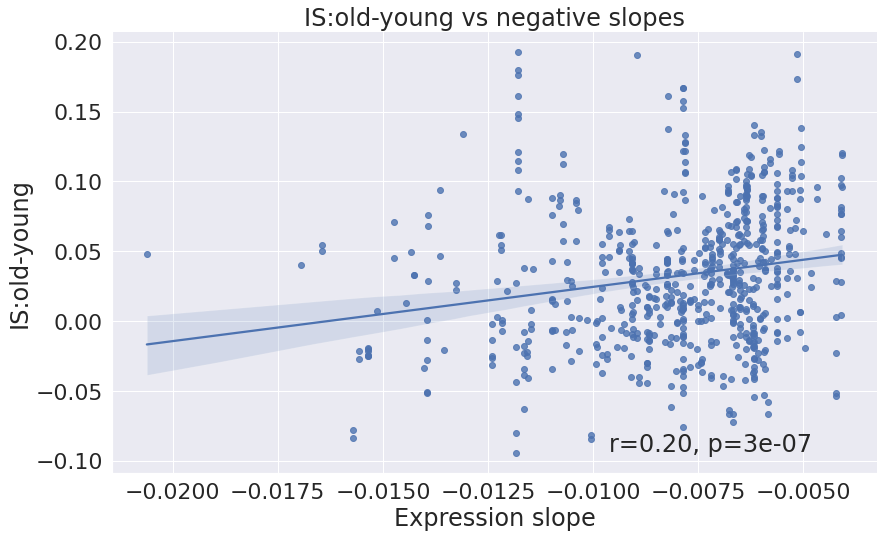

In [169]:
pair = ('old', 'young')
data = intervals_neg_exp#pd.concat([igr_pos, igr_neg])

name = 'IS:' + pair[0] + '-' + pair[1]
data[name] = data.filter(regex=pair[0]).mean(1) -\
                                 data.filter(regex=pair[1]).mean(1)
g = sns.lmplot(y=name, x='logFC', data=data, height=8, aspect=1.6)

def annotate(data, **kws):
    from scipy import stats
    r, p = stats.pearsonr(data['logFC'], data[name],)
    ax = plt.gca()
    ax.text(.65, .05, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)
    ax.set_xlabel('Expression slope')
    ax.set_title(name + ' vs negative slopes')
    
g.map_dataframe(annotate)

In [47]:
intervals_pos_exp.filter(regex='young|old|WT|logFC').corr()['logFC']

logFC             1.000000
WT_female_2       0.086776
WT_female_3       0.079786
WT_male_1         0.075279
old_female_2      0.052280
old_female_3      0.069355
old_male_1        0.069479
young_female_2    0.083711
young_female_3    0.068609
young_male_1      0.079183
Name: logFC, dtype: float64

WT_female_2  WT_female_3  WT_male_1  old_female_2  old_female_3  \
0      -0.806333    -0.842055  -0.817961     -0.691018     -0.759715   
1      -0.626262    -0.668269  -0.647708     -0.513928     -0.540383   
2      -0.504817    -0.561608  -0.488090     -0.415732     -0.382548   
3      -0.052845    -0.060989   0.021204      0.145004      0.080595   
4      -0.203414    -0.152278  -0.106975      0.006436     -0.093497   
..           ...          ...        ...           ...           ...   
655     0.505243     0.402812   0.579525      0.528635      0.455875   
656    -0.644127    -0.488210  -0.684240     -0.540200     -0.612783   
657    -0.084974    -0.152249  -0.185904     -0.176514     -0.155930   
658    -0.181401    -0.155343  -0.262898     -0.248209     -0.185560   
662     0.055509    -0.016734  -0.008589      0.030074      0.039954   

     old_male_1  young_female_2  young_female_3  young_male_1  
0     -0.640139       -0.755641       -0.807805     -0.809376  
1     -0.470029       -0.590704       -0.650991     -0.662328  
2     -0.386714       -0.504710       -0.563001     -0.543770  
3      0.157167        0.064980       -0.025441     -0.053260  
4     -0.015023       -0.097459       -0.113723     -0.174998  
..          ...             ...             ...           ...  
655    0.636435        0.477128        0.522878      0.639246  
656   -0.736987       -0.602273       -0.535458     -0.745974  
657   -0.128187       -0.133215       -0.116486     -0.183581  
658   -0.174989       -0.212963       -0.186797     -0.286330  
662    0.068189       -0.021534       -0.059620      0.019571  

[569 rows x 9 columns]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.155e-07 U_stat=1.305e+06
young v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.223e-02 U_stat=1.528e+06
young v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.246e-02 U_stat=1.374e+06


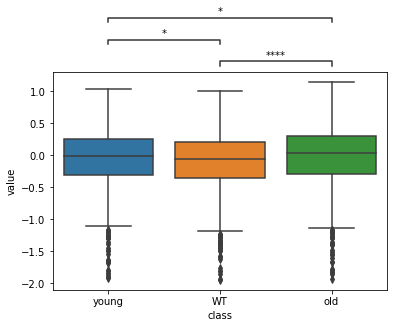

In [49]:
from statannot import add_stat_annotation

tmp = pd.melt(IS_pos_exp)
tmp['class'] = tmp.variable.apply(lambda x: x.split('_')[0])

x = "class"
y = "value"
order = ['young', 'WT', 'old']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("old", "WT"), ("WT", "young"), ('old', 'young')],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.202e-01 U_stat=1.460e+05
young v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.603e+05
young v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.506e+05


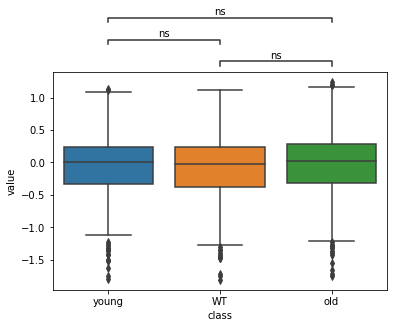

In [50]:
tmp = pd.melt(IS_neg_exp)
tmp['class'] = tmp.variable.apply(lambda x: x.split('_')[0])

x = "class"
y = "value"
order = ['young', 'WT', 'old']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("old", "WT"), ("WT", "young"), ('old', 'young')],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)